## Moteur de recherche sur les données médicales 

Dans ce projet, nous allons construire un moteur de recherche appliqué aux données médicales issues du challenge TREC-COVID. Afin de respecter la logique pédagogique du cours de Recherche d'Information, nous suivrons une approche progressive :

Du modèle le plus simple vers les modèles avancés, en analysant à chaque étape les performances obtenues sur nos données réelles.

### Notre objectif 
**Mettre en œuvre, comparer et analyser différents modèles de recherche d'information, en appliquant l'état de l'art directement sur le corpus TREC-COVID Round 1, un ensemble de documents scientifiques portant sur le COVID-19.**


Nous allons commencer par charger les données (ici les documents sur le COVID), puis les requêtes et les qrels pour ces requêtes 

Nous utilisons la bibliothèque ir_datasets, qui fournit un accès structuré aux documents, aux requêtes (queries) et aux jugements de pertinence (qrels). Cela nous permet de :

- Charger directement le Round 1 du corpus, sans passer par un téléchargement manuel.

- Éviter le scraping des données sur les liens comme :

     - https://ir.nist.gov/covidSubmit/data/topics-rnd1.xml (pour les requêtes)

     - https://ir.nist.gov/covidSubmit/data/qrels-rnd1.txt (pour les qrels)



#### La structure finale de nos données 
- Documents : Articles scientifiques (titre, résumé, etc.)

- Requêtes : Questions médicales posées dans le cadre du challenge

- Qrels : Fichier de pertinence qui indique quels documents sont jugés pertinents pour chaque requête


### Chargement des données grâce à la librairie ir_dataset

In [3]:
import pandas as pd
import ir_datasets
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tqdm import tqdm

# Charger uniquement round1
dataset = ir_datasets.load("cord19/trec-covid/round1")

# Ici nous avons juste un objet fourni par la librairie ir_datasets, 
# qui propose une interface pour accéder aux documents, requêtes, jugements de pertinence, etc.

Nous allons donc maintenant récupérer les documents de ce dataset que nous venons de charger afin de pouvoir les avoir sous forme de dataFrame ainsi on pourra voir le shape, le header...

In [4]:
dataset

Dataset(id='cord19/trec-covid/round1', provides=['docs', 'queries', 'qrels'])

In [2]:
# Préparation
docs = []
for doc in tqdm(dataset.docs_iter(), desc="Chargement des documents"):
    docs.append({
        "doc_id": doc.doc_id,
        "title": doc.title,
        "abstract": doc.abstract
    })

# Conversion en DataFrame
df_docs = pd.DataFrame(docs)

# Affichage
print(df_docs.shape)
print(df_docs.columns)
df_docs.head()


Chargement des documents: 51078it [00:00, 97462.97it/s] 

(51078, 3)
Index(['doc_id', 'title', 'abstract'], dtype='object')


,doc_id,title,abstract
0,xqhn0vbp,Airborne rhinovirus detection and effect of ul...,"BACKGROUND: Rhinovirus, the most common cause ..."
1,gi6uaa83,Discovering human history from stomach bacteria,Recent analyses of human pathogens have reveal...
2,le0ogx1s,A new recruit for the army of the men of death,"The army of the men of death, in John Bunyan's..."
3,fy4w7xz8,Association of HLA class I with severe acute r...,BACKGROUND: The human leukocyte antigen (HLA) ...
4,0qaoam29,A double epidemic model for the SARS propagation,BACKGROUND: An epidemic of a Severe Acute Resp...


### Chargement des queries et des qrels 

Nous allons nous servir de l'objet **dataset** chargé pour obtenir les queries et les qrels 

In [3]:
## Chargement des queries 

queries_iter = dataset.queries_iter()  # ou dataset.queries


Nous pouvons maintenant transformer en dataFrame comme avec les documents précédement 

In [4]:
first_query = next(dataset.queries_iter())
print(first_query)


TrecQuery(query_id='1', title='coronavirus origin', description='what is the origin of COVID-19', narrative="seeking range of information about the SARS-CoV-2 virus's origin, including its evolution, animal source, and first transmission into humans")


In [5]:
queries = []
for q in dataset.queries_iter():
    queries.append({
        "query_id": q.query_id,
        "title": q.title,
        "description": q.description,
        "narrative": q.narrative
    })

queries_df = pd.DataFrame(queries)
queries_df.head()


,query_id,title,description,narrative
0,1,coronavirus origin,what is the origin of COVID-19,seeking range of information about the SARS-Co...
1,2,coronavirus response to weather changes,how does the coronavirus respond to changes in...,seeking range of information about the SARS-Co...
2,3,coronavirus immunity,will SARS-CoV2 infected people develop immunit...,seeking studies of immunity developed due to i...
3,4,how do people die from the coronavirus,what causes death from Covid-19?,Studies looking at mechanisms of death from Co...
4,5,animal models of COVID-19,what drugs have been active against SARS-CoV o...,Papers that describe the results of testing d...


In [6]:
## Chargement des qurels 

queries_iter = dataset.qrels_iter()

On procède comme précédement avec les queries 

In [7]:
qrels = []
for qrel in dataset.qrels_iter():
    qrels.append({
        "query_id": qrel.query_id,
        "doc_id": qrel.doc_id,
        "relevance": qrel.relevance
    })

qrels_df = pd.DataFrame(qrels)
qrels_df.head()


,query_id,doc_id,relevance
0,1,010vptx3,2
1,1,02f0opkr,1
2,1,04ftw7k9,0
3,1,05qglt1f,0
4,1,0604jed8,0


### Nettoyage simple

Nous allons commencer par effectuer un nettoyage simple pour le moment 

- Suppression des NAN
- Concatenation **title + abstract**
- Tokenisation simple 

### Préparation des outils 

In [8]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

tokenizer = RegexpTokenizer(r'\w+')  # Garde uniquement les mots alphanumériques
stop_words = ENGLISH_STOP_WORDS


### Fonction de nettoyage simple 

In [9]:
def clean_text(text):
    tokens = tokenizer.tokenize(text.lower())  # minuscules + tokenisation
    return [token for token in tokens if token not in stop_words] # On garde ceux qui ne sont pas dans la liste des stopwords


### Appliquons le nettoyage sur les documents (corpus)

In [10]:

## On combine le titre et l'abstract 
documents_df = pd.DataFrame([
    {
        "doc_id": doc.doc_id,
        "text": (doc.title or "") + (doc.abstract or "")
    }
    for doc in dataset.docs_iter()
])

# Appliquer le nettoyage
documents_df["tokens"] = documents_df["text"].fillna("").apply(clean_text)



In [11]:
documents_df.head(3)

,doc_id,text,tokens
0,xqhn0vbp,Airborne rhinovirus detection and effect of ul...,"[airborne, rhinovirus, detection, effect, ultr..."
1,gi6uaa83,Discovering human history from stomach bacteri...,"[discovering, human, history, stomach, bacteri..."
2,le0ogx1s,A new recruit for the army of the men of death...,"[new, recruit, army, men, deaththe, army, men,..."


#### Nettoyage des requêtes

In [12]:
queries_df["tokens"] = queries_df["title"].fillna("").apply(clean_text)


On nettoie seulement les titres pour les requêtes car c'est la reformulation courte de la requête et c'est ce que l'utilisateur taperait naturellement dans un moteur de recherche.

*description* et *narrative* décrivent l'intention complète du sujet, mais ils ne sont pas directement utilisés dans les évaluations (TREC utilise *title* par défaut)

In [13]:
queries_df.head(3)

,query_id,title,description,narrative,tokens
0,1,coronavirus origin,what is the origin of COVID-19,seeking range of information about the SARS-Co...,"[coronavirus, origin]"
1,2,coronavirus response to weather changes,how does the coronavirus respond to changes in...,seeking range of information about the SARS-Co...,"[coronavirus, response, weather, changes]"
2,3,coronavirus immunity,will SARS-CoV2 infected people develop immunit...,seeking studies of immunity developed due to i...,"[coronavirus, immunity]"


### Modèle binaire 

Nous allons implémenter un modèle binaire ici et voir ce qui en est des performances, nous terminerons par des commentaire à propos de ce modèle 

- Index inversé (mot et liste des documents où il apparait)
- Requête en mode booléen 
- Recherche des documents concernant certains termes 

Nous ferons une évaluation simple (couverture de la requête)

### Création d'un index inversé sur les documents dont nous venons de faire le nettoyage simple

In [14]:
from collections import defaultdict

def create_inverted_index(docs_tokens):
    """
    docs_tokens : DataFrame avec colonnes ['doc_id', 'tokens']
    Retourne un index inversé : mot → set de doc_ids
    """
    index = defaultdict(set)
    for _, row in docs_tokens.iterrows():
        doc_id = row["doc_id"]
        for token in set(row["tokens"]):  # set pour éviter les doublons
            index[token].add(doc_id) # Constituer l'index inversé
    return dict(index)

# Création de l'index
inverted_index = create_inverted_index(documents_df[["doc_id", "tokens"]])


In [15]:
docs_token = documents_df[['doc_id', 'tokens']]

In [16]:
documents_df['tokens'].head(3)

0    [airborne, rhinovirus, detection, effect, ultr...
1    [discovering, human, history, stomach, bacteri...
2    [new, recruit, army, men, deaththe, army, men,...
Name: tokens, dtype: object

In [ ]:
for _,row in docs_token.iterrows():
    print(row['doc_id'])

### Recherche binaire avec cet index que nous venons de créer 

Ici nous faisons la recherche AND 

In [18]:
def boolean_search(query_tokens, index):
    """
    Effectue une recherche binaire avec opérateur AND.
    query_tokens : liste de tokens nettoyés
    index : dictionnaire mot ==> set(doc_ids)
    Retourne l'ensemble des doc_ids correspondant
    """
    if not query_tokens:
        return set()

    result = index.get(query_tokens[0], set())
    for token in query_tokens[1:]:
        result = result & index.get(token, set())  # Intersection
        if not result:
            break  # optimisation : stop si plus aucun document trouvé
    return result



#### Fonction qui se sert de la recherche pour retourner les documents avec les titres et les abstracts 

In [19]:
def boolean_search_documents(query_text, index, documents_df):
    """
    - query_text : texte brut de la requête (non tokenisé)
    - index : index inversé (mot → doc_ids)
    - documents_df : DataFrame avec ['doc_id', 'text', 'tokens']

    Retourne une liste de dictionnaires avec 'doc_id', 'title', 'abstract'
    """
    query_tokens = clean_text(query_text)
    matched_ids = boolean_search(query_tokens, index)

    # Récupération des documents correspondant aux doc_ids trouvés
    results = documents_df[documents_df['doc_id'].isin(matched_ids)].copy()

    # Extraction séparée du titre et abstract
    results['title'] = results['text'].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    results['abstract'] = results['text'].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))

    return results[['doc_id', 'title', 'abstract']].to_dict(orient='records')



### Exemple d'usage de ce moteur de recherche booléen 

In [20]:
query = "origin of coronavirus"
results_df = boolean_search_documents(query, inverted_index, documents_df)

for row in results_df:
    print(f"\n {row['doc_id']}")
    print(f" Title: {row['title']}")
    print(f" Abstract: {row['abstract'][:300]}...")



 1wswi7us
 Title: Relationship of SARS-CoV to other pathogenic RNA viruses explored by tetranucleotide usage profilingBACKGROUND: The exact origin of the cause of the Severe Acute Respiratory Syndrome (SARS) is still an open question
 Abstract: The genomic sequence relationship of SARS-CoV with 30 different single-stranded RNA (ssRNA) viruses of various families was studied using two non-standard approaches. Both approaches began with the vectorial profiling of the tetra-nucleotide usage pattern V for each virus. In approach one, a distanc...

 8zwsi4nk
 Title: Date of origin of the SARS coronavirus strainsBACKGROUND: A new respiratory infectious epidemic, severe acute respiratory syndrome (SARS), broke out and spread throughout the world
 Abstract: By now the putative pathogen of SARS has been identified as a new coronavirus, a single positive-strand RNA virus. RNA viruses commonly have a high rate of genetic mutation. It is therefore important to know the mutation rate of the SARS c

#### Pour un affichage plus joli

In [21]:
from IPython.display import display, HTML
import pandas as pd
import re


In [22]:
import pandas as pd
import re
from IPython.display import display, HTML

def highlight_keywords(text, keywords):
    """
    Surligne les mots-clés présents dans un texte.
    """
    if not text:
        return ""
    for kw in keywords:
        pattern = re.compile(rf'\b({re.escape(kw)})\b', re.IGNORECASE)
        text = pattern.sub(r'<mark style="background-color: #ffd54f;">\1</mark>', text)
    return text

def display_search_results(results_list, query, max_rows=10, show_scores=True):
    if not results_list:
        display(HTML("<p style='color:red;'>Aucun résultat trouvé.</p>"))
        return

    df = pd.DataFrame(results_list[:max_rows])
    query_tokens = [t.lower() for t in re.findall(r'\w+', query)]

    df["title"] = df["title"].apply(lambda x: highlight_keywords(x, query_tokens))
    df["abstract"] = df["abstract"].apply(lambda x: highlight_keywords(x, query_tokens))

    columns = ["doc_id", "title", "abstract"]
    if show_scores and "score" in df.columns:
        columns.insert(1, "score")

    styled_table = df[columns].style.set_table_attributes("style='width:100%; border-collapse:collapse'")
    styled_table = styled_table.set_properties(**{
        'border': '1px solid #ccc',
        'padding': '8px',
        'text-align': 'left'
    })
    styled_table = styled_table.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#208A9D'), ('color', 'white'), ('font-weight', 'bold')]}
    ])

    display(styled_table)


In [23]:
query = "origin of coronavirus"
results_df = boolean_search_documents(query, inverted_index, documents_df)
display_search_results(results_df, query)


,doc_id,title,abstract
0,1wswi7us,Relationship of SARS-CoV to other pathogenic RNA viruses explored by tetranucleotide usage profilingBACKGROUND: The exact origin of the cause of the Severe Acute Respiratory Syndrome (SARS) is still an open question,"The genomic sequence relationship of SARS-CoV with 30 different single-stranded RNA (ssRNA) viruses of various families was studied using two non-standard approaches. Both approaches began with the vectorial profiling of the tetra-nucleotide usage pattern V for each virus. In approach one, a distance measure of a vector V, based on correlation coefficient was devised to construct a relationship tree by the neighbor-joining algorithm. In approach two, a multivariate factor analysis was performed to derive the embedded tetra-nucleotide usage patterns. These patterns were subsequently used to classify the selected viruses. RESULTS: Both approaches yielded relationship outcomes that are consistent with the known virus classification. They also indicated that the genome of RNA viruses from the same family conform to a specific pattern of word usage. Based on the correlation of the overall tetra-nucleotide usage patterns, the Transmissible Gastroenteritis Virus (TGV) and the Feline CoronaVirus (FCoV) are closest to SARS-CoV. Surprisingly also, the RNA viruses that do not go through a DNA stage displayed a remarkable discrimination against the CpG and UpA di-nucleotide (z = -77.31, -52.48 respectively) and selection for UpG and CpA (z = 65.79,49.99 respectively). Potential factors influencing these biases are discussed. CONCLUSION: The study of genomic word usage is a powerful method to classify RNA viruses. The congruence of the relationship outcomes with the known classification indicates that there exist phylogenetic signals in the tetra-nucleotide usage patterns, that is most prominent in the replicase open reading frames."
1,8zwsi4nk,"Date of origin of the SARS coronavirus strainsBACKGROUND: A new respiratory infectious epidemic, severe acute respiratory syndrome (SARS), broke out and spread throughout the world","By now the putative pathogen of SARS has been identified as a new coronavirus, a single positive-strand RNA virus. RNA viruses commonly have a high rate of genetic mutation. It is therefore important to know the mutation rate of the SARS coronavirus as it spreads through the population. Moreover, finding a date for the last common ancestor of SARS coronavirus strains would be useful for understanding the circumstances surrounding the emergence of the SARS pandemic and the rate at which SARS coronavirus diverge. METHODS: We propose a mathematical model to estimate the evolution rate of the SARS coronavirus genome and the time of the last common ancestor of the sequenced SARS strains. Under some common assumptions and justifiable simplifications, a few simple equations incorporating the evolution rate (K) and time of the last common ancestor of the strains (T(0)) can be deduced. We then implemented the least square method to estimate K and T(0 )from the dataset of sequences and corresponding times. Monte Carlo stimulation was employed to discuss the results. RESULTS: Based on 6 strains with accurate dates of host death, we estimated the time of the last common ancestor to be about August or September 2002, and the evolution rate to be about 0.16 base/day, that is, the SARS coronavirus would on average change a base every seven days. We validated our method by dividing the strains into two groups, which coincided with the results from comparative genomics. CONCLUSION: The applied method is simple to implement and avoid the difficulty and subjectivity of choosing the root of phylogenetic tree. Based on 6 strains with accurate date of host death, we estimated a time of the last common ancestor, which is coincident with epidemic investigations, and an evolution rate in the same range as that reported for the HIV-1 virus."
2,0gmtnkbh,Mutational dynamics of the SARS coronavirus in

### Evaluation de ce moteur de recherche booléen sur les requêtes et les qrels compatibles aux documents qui nous ont servit à construire l'index 

### Une fonction d'évaluation globale que nous allons utiliser dans ce projet 

In [24]:
import numpy as np

def precision_at_k(predicted, relevant, k):
    if not predicted or not relevant:
        return 0.0
    predicted_k = predicted[:k]
    hits = len(set(predicted_k) & set(relevant))
    return hits / k

def recall_at_k(predicted, relevant, k):
    if not predicted or not relevant:
        return 0.0
    predicted_k = predicted[:k]
    return len(set(predicted_k) & set(relevant)) / len(relevant)

def reciprocal_rank(predicted, relevant):
    for idx, doc_id in enumerate(predicted):
        if doc_id in relevant:
            return 1 / (idx + 1)
    return 0.0

def dcg_at_k(relevances, k):
    relevances = np.array(relevances)[:k]
    return np.sum(relevances / np.log2(np.arange(2, relevances.size + 2)))

def ndcg_at_k(predicted, relevant, k):
    relevances = [1 if doc in relevant else 0 for doc in predicted[:k]]
    dcg = dcg_at_k(relevances, k)
    ideal_relevances = sorted(relevances, reverse=True)
    idcg = dcg_at_k(ideal_relevances, k)
    return dcg / idcg if idcg > 0 else 0.0

def f1_score_at_k(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

def average_precision(predicted, relevant):
    """
    Calcule l'Average Precision pour une requête.
    """
    if not relevant:
        return 0.0
    hits = 0
    sum_precisions = 0
    for i, doc_id in enumerate(predicted, start=1):
        if doc_id in relevant:
            hits += 1
            sum_precisions += hits / i
    return sum_precisions / len(relevant)


def evaluate_model(search_function, queries_df, qrels_df, k=10):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    rr_scores = []
    ndcg_scores = []
    map_scores = []

    for _, row in queries_df.iterrows():
        qid = str(row["query_id"])
        query_text = row["title"]

        relevant_docs = qrels_df[qrels_df["query_id"] == qid]["doc_id"].tolist()
        if not relevant_docs:
            continue

        results = search_function(query_text, top_k=k)
        predicted_docs = [r["doc_id"] for r in results]
        if not predicted_docs:
            continue

        precision = precision_at_k(predicted_docs, relevant_docs, k)
        recall = recall_at_k(predicted_docs, relevant_docs, k)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
        rr = reciprocal_rank(predicted_docs, relevant_docs)
        ndcg = ndcg_at_k(predicted_docs, relevant_docs, k)
        ap = average_precision(predicted_docs, relevant_docs)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        rr_scores.append(rr)
        ndcg_scores.append(ndcg)
        map_scores.append(ap)

    return {
        "precision@k": np.mean(precision_scores),
        "recall@k": np.mean(recall_scores),
        "F1@k": np.mean(f1_scores),
        "MRR": np.mean(rr_scores),
        "nDCG@k": np.mean(ndcg_scores),
        "MAP": np.mean(map_scores)
    }


In [25]:
# Wrapper pour inclure les paramètres supplémentaires
def boolean_search_eval_wrapper(query_text, top_k=10):
    results = boolean_search_documents(query_text, inverted_index, documents_df)
    return results[:top_k]

# Évaluation
results_boolean = evaluate_model(boolean_search_eval_wrapper, queries_df, qrels_df, k=10)

# Affichage des résultats
print("Résultats du moteur booléen :")
for metric, score in results_boolean.items():
    print(f"- {metric}: {score:.4f}")


Résultats du moteur booléen :
- precision@k: 0.3185
- recall@k: 0.0132
- F1@k: 0.0253
- MRR: 0.5408
- nDCG@k: 0.5951
- MAP: 0.0113


### Commentaire 

Nous avons les premières évaluations pour ce premier moteur de recherche booléen

Nous constatons que les scores ne sont pas très convainquants à ce niveau, et ceci est dû aux différentes faiblesses de ce type de moteur de recherche, l'ordre des mots n'est pas pris en compte, la recherche est trop stricte, elle est moins flexible


Les résultats obtenus avec ce moteur de recherche booléen montrent des performances modestes


Ces scores traduisent plusieurs limitations du modèle booléen :

- Pas de notion de pertinence graduelle :

    - Le moteur booléen retourne une liste de documents qui correspondent exactement à la requête, sans tenir compte du niveau de pertinence ou de similarité sémantique.

    - Il n’y a aucun score de classement : tous les documents retournés sont considérés égaux.

- Ordre des mots non pris en compte :

    - Le moteur ignore la syntaxe, la sémantique, et l’ordre des mots, ce qui rend les résultats souvent approximatifs ou incomplets.

- Manque de flexibilité :

    - Une requête contenant plusieurs mots-clés doit correspondre exactement à ces termes, même si d'autres documents très pertinents ne contiennent que certains de ces mots ou utilisent des synonymes.

- Faible rappel :

    - Le rappel très faible (~1.3%) indique que de nombreux documents pertinents ne sont pas retournés.

    - Cela reflète le caractère trop strict des requêtes booléennes, qui négligent la richesse du langage naturel.

### Modèle sac de mots (représentation binaire)

- Matrice document-term avec présence (0/1): chaque ligne est un document, chaque mot est une colonne et chaque cellule vaut (0/1) en fonction de si le mot y est ou pas 
- Similarité avec la requête via le nombre de mots communs 

Nous ferons une comparaison naive (cosine binaire)


### Création de la matrice binaire document-term 

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_binary = CountVectorizer(binary=True)  # On veut 0 ou 1, pas les fréquences
X_binary = vectorizer_binary.fit_transform(documents_df["tokens"].apply(lambda tokens: " ".join(tokens)))

# apply(lambda tokens: " ".join(tokens)): On joint les tokens pour obtenir une phrase exploitable par CountVectorizer 


Il s'agit d'une matrice sparse dans laquelle seule les cellules avec des 1 sont retenus afin d'éviter d'avoir une matrice trop creuse 

In [27]:
X_binary # est une matrice n_documents x n_mots 

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3834095 stored elements and shape (51078, 137890)>

In [28]:
vectorizer_binary # contient le mapping mot -> indice de la colonne 

CountVectorizer(binary=True)

### Transformer une requête 

In [29]:
def vectorize_query_binary(query_text):
    query_tokens = clean_text(query_text) 
    query_str = " ".join(query_tokens)  # Afin de pouvoir appliquer la transformation, on forme une phrase avec les tokens 
    return vectorizer_binary.transform([query_str]) # On vectorise avec le même vectorizer que pour les documents donc le même vocabulaire


### Calcul de la similarité cosinus 

On calcule la similarité entre la requête et chaque document

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def search_binary(query_text, top_k=10):
    query_vec = vectorize_query_binary(query_text)
    scores = cosine_similarity(query_vec, X_binary).flatten()
    top_indices = scores.argsort()[::-1][:top_k]
    return documents_df.iloc[top_indices][['doc_id', 'text']].assign(score=scores[top_indices]).to_dict(orient='records')


def search_binary_document(query_text, documents_df, top_k=10):
    """
    Recherche binaire avec affichage enrichi trié par score.
    """
    raw_results = search_binary(query_text, top_k=top_k)

    if not raw_results:
        return []

    # Extraire les doc_ids
    matched_ids = [r['doc_id'] for r in raw_results]
    score_dict = {r['doc_id']: r['score'] for r in raw_results}

    # Récupérer les documents correspondants
    results = documents_df[documents_df["doc_id"].isin(matched_ids)].copy()

    # Ajouter titre / abstract
    results["title"] = results["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    results["abstract"] = results["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))

    # Ajouter les scores puis trier
    results["score"] = results["doc_id"].map(score_dict)
    results = results.sort_values(by="score", ascending=False)

    return results[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")



In [31]:
### Exemple d'application sur une requête: 

query = "origin of COVID-19"

search_binary_document(query_text=query, documents_df=documents_df, top_k=3)

[{'doc_id': 'gv1k7u7j',
  'title': 'Strategies to trace back the origin of COVID-19',
  'abstract': 'Strategies to trace back the origin of COVID-19',
  'score': 0.7745966692414834},
 {'doc_id': '8m3wg1tg',
  'title': 'O Anestesiologista e a COVID-19',
  'abstract': 'O Anestesiologista e a COVID-19',
  'score': 0.6666666666666669},
 {'doc_id': '3gbxbg5f',
  'title': 'COVID-19 and Interconnectedness',
  'abstract': 'COVID-19 and Interconnectedness',
  'score': 0.6666666666666669}]

In [32]:
query = "origin of COVID-19"
results = search_binary_document(query, documents_df, top_k=3)
display_search_results(results, query)


,doc_id,score,title,abstract
0,gv1k7u7j,0.774597,Strategies to trace back the origin of COVID-19,Strategies to trace back the origin of COVID-19
1,8m3wg1tg,0.666667,O Anestesiologista e a COVID-19,O Anestesiologista e a COVID-19
2,3gbxbg5f,0.666667,COVID-19 and Interconnectedness,COVID-19 and Interconnectedness


In [33]:
results_binary = evaluate_model(search_binary, queries_df, qrels_df, k=10)

print("Résultats du modèle sac de mots (binaire) :")
for metric, score in results_binary.items():
    print(f"- {metric}: {score:.4f}")


Résultats du modèle sac de mots (binaire) :
- precision@k: 0.0667
- recall@k: 0.0025
- F1@k: 0.0049
- MRR: 0.3235
- nDCG@k: 0.3803
- MAP: 0.0013


### Commentaire

 Le modèle sac de mots binaire montre une précision très faible (6%) et un rappel quasi nul (0,2%), ce qui signifie qu'il retrouve peu de documents pertinents dans les premiers résultats. Cela peut s’expliquer par le fait que cette représentation (0/1) ne prend ni en compte la fréquence des mots ni leur importance contextuelle, rendant les résultats peu discriminants.

### Fréquence des mots (Term Frequency): Une variante du modèle sac de mots

- Poids selon le nombre d’occurrences dans le document.

- Matrice pondérée.

- Cosine similarity avec une requête vectorisée également.

#### Création de la matrice term-document basé sur les fréquences des mots dans les documents 

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

# On réutilise les documents nettoyés précédemment
tf_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)  # car nos tokens sont déjà nettoyés
X_tf = tf_vectorizer.fit_transform(documents_df["tokens"])


C:\Users\12407156\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Fonction pour vectoriser la requête avec le même vocabulaire 

In [35]:
def vectorize_query_tf(query_text):
    tokens = clean_text(query_text)
    return tf_vectorizer.transform([tokens])


#### Fonction de recherche avec similarité cosinus 

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

def search_tf(query_text, top_k=10):
    query_vec = vectorize_query_tf(query_text)
    scores = cosine_similarity(query_vec, X_tf).flatten()
    top_indices = scores.argsort()[::-1][:top_k]
    
    results = documents_df.iloc[top_indices].copy()
    results["score"] = scores[top_indices]
    
    # Séparer titre / abstract
    results["title"] = results["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    results["abstract"] = results["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))
    
    return results[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")


#### Exemple de recherche 

In [37]:
query = "origin of COVID-19"
results = search_tf(query, top_k=10)
display_search_results(results, query)


,doc_id,score,title,abstract
0,gv1k7u7j,0.774597,Strategies to trace back the origin of COVID-19,Strategies to trace back the origin of COVID-19
1,3gbxbg5f,0.666667,COVID-19 and Interconnectedness,COVID-19 and Interconnectedness
2,450z0tv1,0.666667,The Anesthesiologist and COVID-19,The Anesthesiologist and COVID-19
3,pttcysvc,0.666667,"COVID-19, a pandemic or not?","COVID-19, a pandemic or not?"
4,s7idehep,0.666667,"Medicine: before COVID-19, and after","Medicine: before COVID-19, and after"
5,s4dqx9en,0.636524,Plasma Metabolomic and Lipidomic Alterations Associated with COVID-19The pandemic of the coronavirus disease 2019 (COVID-19) has become a global public health crisis,"COVID-19 is marked by its rapid progression from mild to severe conditions, particularly in the absence of adequate medical care. However, the physiological changes associated with COVID-19 are barely understood. In this study, we performed untargeted metabolomic and lipidomic analyses of plasma from a cohort of COVID-19 patients who had experienced different symptoms. We found the metabolite and lipid alterations exhibit apparent correlation with the course of disease in these COVID-19 patients, indicating that the development of COVID-19 affected patient metabolism. Moreover, many of the metabolite and lipid alterations, particularly ones associated with hepatic functions, have been found to align with the progress and severity of COVID-19. This work provides valuable knowledge about blood biomarkers associated with COVID-19 and potential therapeutic targets, and presents important resource for further studies of COVID-19 pathogenesis."
6,awitk3se,0.620337,"COVID-19 (Novel Coronavirus 2019) - recent trendsThe World Health Organization (WHO) has issued a warning that, although the 2019 novel coronavirus (COVID-19) from Wuhan City (China), is not pandemic, it should be contained to prevent the global spread","The COVID-19 virus was known earlier as 2019-nCoV. As of 12 February 2020, WHO reported 45,171 cases and 1115 deaths related to COVID-19. COVID-19 is similar to Severe Acute Respiratory Syndrome coronavirus (SARS-CoV) virus in its pathogenicity, clinical spectrum, and epidemiology. Comparison of the genome sequences of COVID-19, SARS-CoV, and Middle East Respiratory Syndrome coronavirus (MERS-CoV) showed that COVID-19 has a better sequence identity with SARS-CoV compared to MERS CoV. However, the amino acid sequence of COVID-19 differs from other coronaviruses specifically in the regions of 1ab polyprotein and surface glycoprotein or S-protein. Although several animals have been speculated to be a reservoir for COVID-19, no animal reservoir has been already confirmed. COVID-19 causes COVID-19 disease that has similar symptoms as SARS-CoV. Studies suggest that the human receptor for COVID-19 may be angiotensin-converting enzyme 2 (ACE2) receptor similar to that of SARS-CoV. The nucleocapsid (N) protein of COVID-19 has nearly 90% amino acid sequence identity with SARS-CoV. The N protein antibodies of SARS-CoV may cross react with COVID-19 but may not provide cross-immunity. In a similar fashion to SARS-CoV, the N protein of COVID-19 may play an important role in suppressing the RNA interference (RNAi) to overcome the host defense. This mini-review aims at investigating the most recent trend of COVID-19."
7,sjyrr2bn,0.605228,"COVID-19: A promising cure for the global panicAbstract The novel Coronavirus disease 2019 (COVID-19) is caused by SARS-CoV-2, which is the causative agent of a potentially fatal disease that is of great global public health concern","The outbreak of COVID-19 is wreaking havoc worldwide due to inadequate risk assessment regarding the urgency of the situation. The COVID-19 pandemic has entered a dangerous new phase. When compared with SARS and MERS, COVID-19 has spread more rapidly, due to increased globalization and adaptation of the virus in every environment. Slowing the spread of the COVID-19 cases will significantly reduce the s

#### Evaluation du moteur de recherche tf

In [38]:
results_tf = evaluate_model(search_tf, queries_df, qrels_df, k=10)

print("Résultats du modèle sac de mots (tf) :")
for metric, score in results_tf.items():
    print(f"- {metric}: {score:.4f}")


Résultats du modèle sac de mots (tf) :
- precision@k: 0.1733
- recall@k: 0.0067
- F1@k: 0.0128
- MRR: 0.4356
- nDCG@k: 0.5374
- MAP: 0.0035


### Commentaire 
Ici on constate une légère amélioration des scores 

Comme nous l'avions dit précédemment, le moteur binaire ne prenait pas en compte la fréquence des mots. Ce nouveau moteur ne prend certe pas en compte le contexte (semantique), l'ordre des mots, mais il est mieux que le modèle précédent et mieux que le modèle booléen que nous avons effectué plus haut 

### TF-IDF (Term Frequency-Inverse Document Frequency)

- Ici nous ajoutons l'aspect de rareté au moteur précédent (TF)
-  Nous allons faire une évaluation (Précision, rappel, nDCG, MRR (découvert lors des recherches, qui permet de savoir si le premier document est toujours celui qui est pertinent))

**MRR** : Mean Reciprocal Rank, si le document pertinent est à la position 1 alors le score est de 1, si c'est en deuxième, le score est de 1/2 ainsi de suite. Puis on fait la moyenne de tous ces scores ce qui donne le MRR global, si cela vaut 1 alors le moteur de recherche met toujours le document pertinent comme premier document 

### Construction de la matrice tf-idf 

Ici, à la place des fréquences, on utilise les poids tfidf = tf x idf (tf = nombre d'occurence du mot divisé par la taille du vocabulaire, idf = logarithme du nombre total de documents, divisé par le nombre de documents dans lequels le mots apparait)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(documents_df["tokens"].apply(lambda tokens: " ".join(tokens)))

In [40]:
documents_df.shape

(51078, 3)

#### Vectorisation de la requête avec le même vectorizer 

In [41]:
def vectorize_query_tfidf(query_text):
    tokens = clean_text(query_text)
    query_string = " ".join(tokens)
    return vectorizer_tfidf.transform([query_string])


#### Recherche par similarité cosinus 

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

def search_tfidf(query_text, top_k=10):
    # Dans cette fonction de recherche on applique sur la requête la vectorisation avec le même vectorizer qu'on a utilisé pour les 
    # documents afin de pouvoir faire le calcul de similarité cosinus entre la requête et les documents
    query_vec = vectorize_query_tfidf(query_text)
    scores = cosine_similarity(query_vec, X_tfidf).flatten()
    top_indices = scores.argsort()[::-1][:top_k]
    
    results = documents_df.iloc[top_indices].copy()
    results["score"] = scores[top_indices]
    results["title"] = results["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    results["abstract"] = results["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))
    
    return results[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")


#### Test sur la requête 

In [43]:
query = "origin of COVID-19"
display_search_results(search_tfidf(query, top_k=10), query)


,doc_id,score,title,abstract
0,gv1k7u7j,0.660956,Strategies to trace back the origin of COVID-19,Strategies to trace back the origin of COVID-19
1,pttcysvc,0.584060,"COVID-19, a pandemic or not?","COVID-19, a pandemic or not?"
2,13veedct,0.553684,COVID-19 infection in children,COVID-19 infection in children
3,1g2mup0k,0.553567,COVID-19: what is next for public health?,COVID-19: what is next for public health?
4,awitk3se,0.551013,"COVID-19 (Novel Coronavirus 2019) - recent trendsThe World Health Organization (WHO) has issued a warning that, although the 2019 novel coronavirus (COVID-19) from Wuhan City (China), is not pandemic, it should be contained to prevent the global spread","The COVID-19 virus was known earlier as 2019-nCoV. As of 12 February 2020, WHO reported 45,171 cases and 1115 deaths related to COVID-19. COVID-19 is similar to Severe Acute Respiratory Syndrome coronavirus (SARS-CoV) virus in its pathogenicity, clinical spectrum, and epidemiology. Comparison of the genome sequences of COVID-19, SARS-CoV, and Middle East Respiratory Syndrome coronavirus (MERS-CoV) showed that COVID-19 has a better sequence identity with SARS-CoV compared to MERS CoV. However, the amino acid sequence of COVID-19 differs from other coronaviruses specifically in the regions of 1ab polyprotein and surface glycoprotein or S-protein. Although several animals have been speculated to be a reservoir for COVID-19, no animal reservoir has been already confirmed. COVID-19 causes COVID-19 disease that has similar symptoms as SARS-CoV. Studies suggest that the human receptor for COVID-19 may be angiotensin-converting enzyme 2 (ACE2) receptor similar to that of SARS-CoV. The nucleocapsid (N) protein of COVID-19 has nearly 90% amino acid sequence identity with SARS-CoV. The N protein antibodies of SARS-CoV may cross react with COVID-19 but may not provide cross-immunity. In a similar fashion to SARS-CoV, the N protein of COVID-19 may play an important role in suppressing the RNA interference (RNAi) to overcome the host defense. This mini-review aims at investigating the most recent trend of COVID-19."
5,s7idehep,0.546831,"Medicine: before COVID-19, and after","Medicine: before COVID-19, and after"
6,tq0dzwy1,0.504460,The Coronavirus Disease 2019 (COVID-19),The Coronavirus Disease 2019 (COVID-19)
7,sjyrr2bn,0.501568,"COVID-19: A promising cure for the global panicAbstract The novel Coronavirus disease 2019 (COVID-19) is caused by SARS-CoV-2, which is the causative agent of a potentially fatal disease that is of great global public health concern","The outbreak of COVID-19 is wreaking havoc worldwide due to inadequate risk assessment regarding the urgency of the situation. The COVID-19 pandemic has entered a dangerous new phase. When compared with SARS and MERS, COVID-19 has spread more rapidly, due to increased globalization and adaptation of the virus in every environment. Slowing the spread of the COVID-19 cases will significantly reduce the strain on the healthcare system of the country by limiting the number of people who are severely sick by COVID-19 and need hospital care. Hence, the recent outburst of COVID-19 highlights an urgent need for therapeutics targeting SARS-CoV-2. Here, we have discussed the structure of virus; varying symptoms among COVID-19, SARS, MERS and common flu; the probable mechanism behind the infection and its immune response. Further, the current treatment options, drugs available, ongoing trials and recent diagnostics for COVID-19 have been discussed. We suggest traditional Indian medicinal plants as possible novel therapeutic approaches, exclusively targeting SARS-CoV-2 and its pathways."
8,05xedq1l,0.501422,COVID-19 Therapeutic and Prevention,COVID-19 Therapeutic and Prevention
9,s4dqx9en,0.491117,Plasma Metabolomic and Lipidomic Alterations Associated with COVID-19The pandemic of the coronavirus disease 2019 (COVID-19) has become a global public health crisis,"COVID-19 is marked by its rapid progression from mild to se

#### Evaluation du moteur de recherche 

In [44]:
results_tfidf = evaluate_model(search_tfidf, queries_df, qrels_df, k=10)

print("Résultats du modèle TF-IDF :")
for metric, score in results_tfidf.items():
    print(f"- {metric}: {score:.4f}")


Résultats du modèle TF-IDF :
- precision@k: 0.5233
- recall@k: 0.0205
- F1@k: 0.0394
- MRR: 0.6667
- nDCG@k: 0.7355
- MAP: 0.0164


### Commentaire

L'ajout de la notion de rareté des termes à travers le TF-IDF marque un tournant significatif dans la qualité du moteur de recherche. On observe une amélioration notable de toutes les métriques, notamment une nDCG@k de 73%, indiquant que les documents jugés pertinents sont désormais mieux classés dans les résultats.

Ce modèle commence à véritablement capturer l'intention des requêtes. Pour aller plus loin, nous allons explorer des techniques de prétraitement plus poussées afin d’affiner encore davantage la pertinence des documents retournés.

### Représentation graphique des scores en fonction des valeurs de k 

In [45]:
ks = list(range(5, 200, 5))
precision_scores = []
recall_scores = []
ndcg_scores = []

for k in ks:
    results = evaluate_model(search_tfidf, queries_df, qrels_df, k=k)
    precision_scores.append(results["precision@k"])
    recall_scores.append(results["recall@k"])
    ndcg_scores.append(results['nDCG@k'])


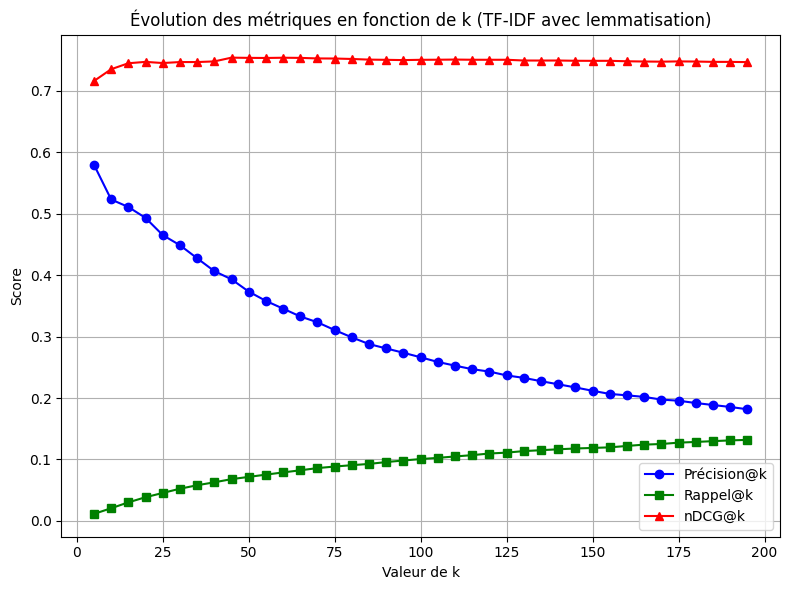

In [46]:
import matplotlib.pyplot as plt

# Supposons que tu as déjà ces listes
# ks, precision_scores, recall_scores, ndcg_scores

plt.figure(figsize=(8, 6))

# Tracer chaque courbe avec un marqueur et une couleur
plt.plot(ks, precision_scores, label='Précision@k', color='blue', marker='o')
plt.plot(ks, recall_scores, label='Rappel@k', color='green', marker='s')
plt.plot(ks, ndcg_scores, label='nDCG@k', color='red', marker='^')

# Ajouter les labels et titre
plt.xlabel('Valeur de k')
plt.ylabel('Score')
plt.title("Évolution des métriques en fonction de k (TF-IDF avec lemmatisation)")

# Ajouter une légende
plt.legend(loc='lower right')

# Ajouter une grille pour plus de lisibilité
plt.grid(True)

# Affichage
plt.tight_layout()
plt.show()


### Ce comportement est typique des moteurs de recherche, plus on ajoute des documents plus on a la chance d'avoir des documents pertinents ce qui augmente le rappel. Mais au contraire on ramène plus de documents non pertinent ce qui réduit la précision. Donc il est presque difficile d'avoir la précision et le rappel très grand surtout avec ce grand jeu de données, c'est pourquoi notre objectif sera plutot de rendre les premiers résultats pertinents (voir MRR et nDCG grands)

### Prétraitement avancé et application avec le moteur TF-IDF 

Nous allons maintenant :

1. Appliquer la lemmatisation (réduction des mots à leur forme canonique) avec spaCy pour rendre les textes plus homogènes.

2. Utiliser un dictionnaire de synonymes (que nous allons constituer nous même pour le moment car nous n'avons pas pu avoir accès au dictionnaire MeSH, UMLS ou un thesaurus médical simple) afin de détecter les variantes terminologiques fréquentes dans les documents médicaux. Cela permettra :

    - D’élargir la couverture des requêtes (récupérer plus de documents pertinents).

    - D’améliorer le rappel sans trop sacrifier la précision.

3. la suppression des stopwords,

4. le filtrage alphabetique,

5. l’enrichissement avec un dictionnaire de synonymes (comme le medical_synonyms que nous allons définir).



### Lemmatisation sur les documents (nous avons déjà combiné le titre et l'abstract) 

In [47]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.6/12.8 MB 8.3 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 9.5 MB/s eta 0:00:01
     ------------------ --------------------- 6.0/12.8 MB 10.0 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 10.4 MB/s eta 0:00:01
     --------------------------------- ----- 11.0/12.8 MB 10.6 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 10.0 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 9.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\12407156\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import spacy
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Initialisation
nlp = spacy.load("en_core_web_sm")
tokenizer = RegexpTokenizer(r'\w+')
stop_words = ENGLISH_STOP_WORDS

# Dictionnaire médical enrichi
medical_synonyms = {
    "covid": ["covid19", "covid-19", "coronavirus", "sars-cov-2", "2019-ncov", "covid19 virus"],
    "coronavirus": ["sars-cov-2", "2019-ncov", "covid"],
    "pandemic": ["epidemic", "outbreak", "pandemia"],
    "mask": ["face mask", "surgical mask", "n95", "respirator"],
    "quarantine": ["isolation", "lockdown", "social distancing"],
    "vaccine": ["vaccination", "immunization", "inoculation", "jab"],
    "infection": ["contamination", "transmission", "infectious disease"],
    "treatment": ["therapy", "medication", "intervention", "cure"],
    "hospital": ["clinic", "medical center", "healthcare facility"],
    "symptom": ["clinical sign", "manifestation", "indicator"],
    "fever": ["pyrexia", "high temperature"],
    "cough": ["dry cough", "wet cough"],
    "breathlessness": ["shortness of breath", "dyspnea"],
    "fatigue": ["tiredness", "exhaustion", "lethargy"],
    "headache": ["cephalalgia", "migraine"],
    "diabetes": ["hyperglycemia", "type 2 diabetes", "type 1 diabetes"],
    "heart disease": ["cardiovascular disease", "cardiac disease"],
    "lung": ["pulmonary", "respiratory system"],
    "death": ["mortality", "fatality"],
    "testing": ["diagnosis", "diagnostic", "screening"],
    "variant": ["strain", "mutation", "lineage"],
    "research": ["study", "analysis", "investigation"],
    "health": ["wellness", "medical", "care"],
    "immune": ["immunity", "resistance", "defense system"],
    "virus": ["pathogen", "microbe", "infectious agent"],
    "contagion": ["transmissibility", "spread", "infectivity"],
    "lockdown": ["confinement", "shutdown", "restriction"]
}

# Inversion pour que chaque synonyme pointe vers le mot canonique
synonym_map = {}
for canonical, syns in medical_synonyms.items():
    synonym_map[canonical] = canonical
    for s in syns:
        synonym_map[s] = canonical

def preprocess_advanced(text):
    """
    Nettoyage + lemmatisation + remplacement par mot canonique selon dictionnaire.
    """
    doc = nlp(text.lower())
    processed_tokens = []
    
    for token in doc:
        if token.is_alpha and token.text not in stop_words and not token.is_stop:
            lemma = token.lemma_
            canonical = synonym_map.get(lemma, lemma)
            processed_tokens.append(canonical)
    
    return " ".join(processed_tokens)


### Application sur les documents 

In [49]:
from tqdm import tqdm

tqdm.pandas()

# Ajoute une nouvelle colonne "processed_text"
documents_df["processed_text"] = documents_df["text"].progress_apply(preprocess_advanced)


100%|██████████| 51078/51078 [31:17<00:00, 27.20it/s]  


### Application sur les requêtes

In [50]:
queries_df["processed_title"] = queries_df["title"].progress_apply(preprocess_advanced)


100%|██████████| 30/30 [00:00<00:00, 182.88it/s]


In [51]:
queries_df.shape

(30, 6)

### Construction de la nouvelle matrice tf-idf avec ces données prétraitées

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(documents_df["processed_text"])

### Vectorisation de la requête avec le même vectorizer 

In [53]:
def vectorize_query_tfidf(query_text):
    query_processed = preprocess_advanced(query_text)
    return vectorizer_tfidf.transform([query_processed])


### Recherche par similarité cosinus 

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

def search_tfidf(query_text, top_k=10):
    query_vec = vectorize_query_tfidf(query_text)
    scores = cosine_similarity(query_vec, X_tfidf).flatten()
    top_indices = scores.argsort()[::-1][:top_k]
    
    results = documents_df.iloc[top_indices].copy()
    results["score"] = scores[top_indices]
    results["title"] = results["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    results["abstract"] = results["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))
    
    return results[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")


#### Application sur une requête 

In [55]:
query = "origin of COVID-19"
display_search_results(search_tfidf(query, top_k=10), query)


,doc_id,score,title,abstract
0,73xil5op,0.565891,Bat origin of a new human coronavirus: there and back again,Bat origin of a new human coronavirus: there and back again
1,gv1k7u7j,0.553640,Strategies to trace back the origin of COVID-19,Strategies to trace back the origin of COVID-19
2,jphbdxhw,0.517366,Early life origins of asthma,Early life origins of asthma
3,9dj07sac,0.467781,"The prevalence, origin, and prevention of six human coronaviruses[Image: see text]","The prevalence, origin, and prevention of six human coronaviruses[Image: see text]"
4,80e5xkht,0.447901,Reacting to the emergence of swine-origin influenza A H1N1,Reacting to the emergence of swine-origin influenza A H1N1
5,9i8z6l3a,0.444004,Animal Origins of the Severe Acute Respiratory Syndrome Coronavirus: Insight from ACE2-S-Protein Int,Animal Origins of the Severe Acute Respiratory Syndrome Coronavirus: Insight from ACE2-S-Protein Interactions
6,gyj5213f,0.438252,"Origins of MERS-CoV, and lessons for 2019-nCoV","Origins of MERS-CoV, and lessons for 2019-nCoV"
7,6foz003n,0.409651,Diversity of Coronaviruses in Bats: Insights Into Origin of SARS Coronavirus,Diversity of Coronaviruses in Bats: Insights Into Origin of SARS Coronavirus
8,wuegn0jg,0.406891,Bat-Origin Coronaviruses Expand Their Host Range to PigsInfections with bat-origin coronaviruses have caused severe illness in humans by ‘host jump’,"Recently, novel bat-origin coronaviruses were found in pigs. The large number of mutations on the receptor-binding domain allowed the viruses to infect the new host, posing a potential threat to both agriculture and public health."
9,ycvu5l5f,0.387537,A glimpse into the origins of genetic diversity in SARS-CoV-2,A glimpse into the origins of genetic diversity in SARS-CoV-2


#### Evaluation du moteur de recherche 

In [56]:
results_tfidf = evaluate_model(search_tfidf, queries_df, qrels_df, k=100)

print("Résultats du modèle TF-IDF avec prétraitement avancé :")
for metric, score in results_tfidf.items():
    print(f"- {metric}: {score:.4f}")


Résultats du modèle TF-IDF avec prétraitement avancé :
- precision@k: 0.2573
- recall@k: 0.0978
- F1@k: 0.1406
- MRR: 0.6958
- nDCG@k: 0.7480
- MAP: 0.0568


#### Commentaire 

Avec ces prétraitements avancés, on constate que la précision diminue, mais le rappel, le f1-score, le MRR et le nDCG augmentent ce qui n'est pas négligeable car si le rappel augmente cela veut dire qu'il y a plus de documents pertinents et sir nDCG augmente cela veut dire que ces documents pertinents sont placés dans les débuts. Ces scores varient en fonction de la valeur de k, du coup, nous allons effectuer un graphe d'évolution de ces scores en fonctions de k avec une légende pour plus de lisibilité 

In [57]:
ks = list(range(5, 200, 5))
precision_scores = []
recall_scores = []
ndcg_scores = []

for k in ks:
    results = evaluate_model(search_tfidf, queries_df, qrels_df, k=k)
    precision_scores.append(results["precision@k"])
    recall_scores.append(results["recall@k"])
    ndcg_scores.append(results['nDCG@k'])


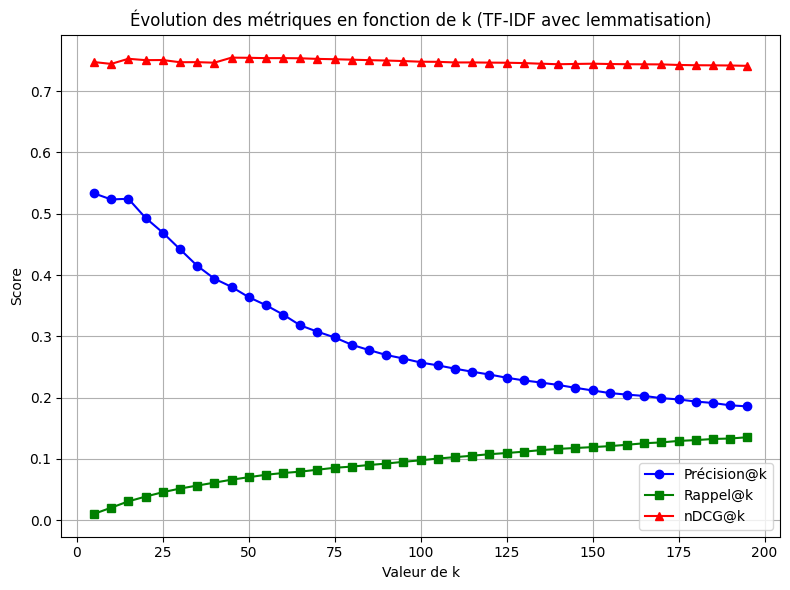

In [58]:
import matplotlib.pyplot as plt

# Supposons que tu as déjà ces listes
# ks, precision_scores, recall_scores, ndcg_scores

plt.figure(figsize=(8, 6))

# Tracer chaque courbe avec un marqueur et une couleur
plt.plot(ks, precision_scores, label='Précision@k', color='blue', marker='o')
plt.plot(ks, recall_scores, label='Rappel@k', color='green', marker='s')
plt.plot(ks, ndcg_scores, label='nDCG@k', color='red', marker='^')

# Ajouter les labels et titre
plt.xlabel('Valeur de k')
plt.ylabel('Score')
plt.title("Évolution des métriques en fonction de k (TF-IDF avec lemmatisation)")

# Ajouter une légende
plt.legend(loc='lower right')

# Ajouter une grille pour plus de lisibilité
plt.grid(True)

# Affichage
plt.tight_layout()
plt.show()


### Interprétation, 

Le rappel lui même ne semble pas vouloir vraiment évoluer malgré les valeurs grandes de k qu'on lui donne.

Mais l'idéal serait d'avoir un MRR = 1 et un nDCG qui se rapproche beaucoup plus de 1 

In [59]:
results_tfidf = evaluate_model(search_tfidf, queries_df, qrels_df, k=100)

print("Résultats du modèle TF-IDF avec prétraitement avancé :")
for metric, score in results_tfidf.items():
    print(f"- {metric}: {score:.4f}")


Résultats du modèle TF-IDF avec prétraitement avancé :
- precision@k: 0.2573
- recall@k: 0.0978
- F1@k: 0.1406
- MRR: 0.6958
- nDCG@k: 0.7480
- MAP: 0.0568


#### L'odre des mots peut aussi être la cause de tout ceci, nous allons rester avec ces prétraitements, mais nous allons plutot effectuer un moteur basé sur les n-grammes 

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # unigrammes + bigrammes
    max_df=0.95,
    min_df=2,
    max_features=20000,
    stop_words='english'
)

X_tfidf_ngramm = vectorizer.fit_transform(documents_df["processed_text"])  # si texte déjà nettoyé/lemmatisé


#### Appliquons aussi ce vectorizer sur les requêtes

In [61]:
def vectorize_query_tfidf(query_text):
    query_processed = preprocess_advanced(query_text)
    return vectorizer.transform([query_processed])


#### Similarité cosinus 

In [62]:
from sklearn.metrics.pairwise import cosine_similarity

def search_tfidf(query_text, top_k=10):
    query_vec = vectorize_query_tfidf(query_text)
    scores = cosine_similarity(query_vec, X_tfidf_ngramm).flatten()
    top_indices = scores.argsort()[::-1][:top_k]
    
    results = documents_df.iloc[top_indices].copy()
    results["score"] = scores[top_indices]
    results["title"] = results["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    results["abstract"] = results["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))
    
    return results[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")


#### Exemple d'application sur une requête 

In [63]:
query = "origin of COVID-19"
display_search_results(search_tfidf(query, top_k=10), query)


,doc_id,score,title,abstract
0,gv1k7u7j,0.553640,Strategies to trace back the origin of COVID-19,Strategies to trace back the origin of COVID-19
1,9dj07sac,0.467781,"The prevalence, origin, and prevention of six human coronaviruses[Image: see text]","The prevalence, origin, and prevention of six human coronaviruses[Image: see text]"
2,ycvu5l5f,0.455356,A glimpse into the origins of genetic diversity in SARS-CoV-2,A glimpse into the origins of genetic diversity in SARS-CoV-2
3,gyj5213f,0.403088,"Origins of MERS-CoV, and lessons for 2019-nCoV","Origins of MERS-CoV, and lessons for 2019-nCoV"
4,vp5358rr,0.398471,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME
5,vp5358rr,0.398471,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME
6,jphbdxhw,0.397933,Early life origins of asthma,Early life origins of asthma
7,49360l2a,0.366003,A phylogenomic data-driven exploration of viral origins and evolutionThe origin of viruses remains mysterious because of their diverse and patchy molecular and functional makeup,"Although numerous hypotheses have attempted to explain viral origins, none is backed by substantive data. We take full advantage of the wealth of available protein structural and functional data to explore the evolution of the proteomic makeup of thousands of cells and viruses. Despite the extremely reduced nature of viral proteomes, we established an ancient origin of the “viral supergroup” and the existence of widespread episodes of horizontal transfer of genetic information. Viruses harboring different replicon types and infecting distantly related hosts shared many metabolic and informational protein structural domains of ancient origin that were also widespread in cellular proteomes. Phylogenomic analysis uncovered a universal tree of life and revealed that modern viruses reduced from multiple ancient cells that harbored segmented RNA genomes and coexisted with the ancestors of modern cells. The model for the origin and evolution of viruses and cells is backed by strong genomic and structural evidence and can be reconciled with existing models of viral evolution if one considers viruses to have originated from ancient cells and not from modern counterparts."
8,ec8lpgl3,0.325618,"Scientists ‘strongly condemn’ rumors and conspiracy theories about origin of coronavirus outbreak | Science | AAASA group of 27 prominent public health scientists from outside China is pushing back against a steady stream of stories and even a scientific paper suggesting a laboratory in Wuhan, China, may be the origin of the outbreak of COVID-19","“The rapid, open, and transparent sharing of data on this outbreak is now being threatened by rumours and misinformation around its origins,” the scientists, from nine countries, write in a statement published online by The Lancet yesterday"
9,73xil5op,0.317464,Bat origin of a new human coronavirus: there and back again,Bat origin of a new human coronavirus: there and back again


In [64]:
results_tfidf = evaluate_model(search_tfidf, queries_df, qrels_df, k=75)

print("Résultats du modèle TF-IDF avec prétraitement avancé avec n-gramme :")
for metric, score in results_tfidf.items():
    print(f"- {metric}: {score:.4f}")


Résultats du modèle TF-IDF avec prétraitement avancé avec n-gramme :
- precision@k: 0.2982
- recall@k: 0.0864
- F1@k: 0.1330
- MRR: 0.6226
- nDCG@k: 0.7040
- MAP: 0.0490


### Commentaire

On constate que ceci a plutôt réduit le nDCG ce qui n'était pas le cas lorsqu'on ne l'a pas utilisé 

Donc l'ordre des mots n'est pas vraiment un problème ici

#### Plot des scores en fonction de k pour ce moteur avec n-gramme

In [65]:
ks = list(range(5, 200, 5))
precision_scores = []
recall_scores = []
ndcg_scores = []

for k in ks:
    results = evaluate_model(search_tfidf, queries_df, qrels_df, k=k)
    precision_scores.append(results["precision@k"])
    recall_scores.append(results["recall@k"])
    ndcg_scores.append(results['nDCG@k'])


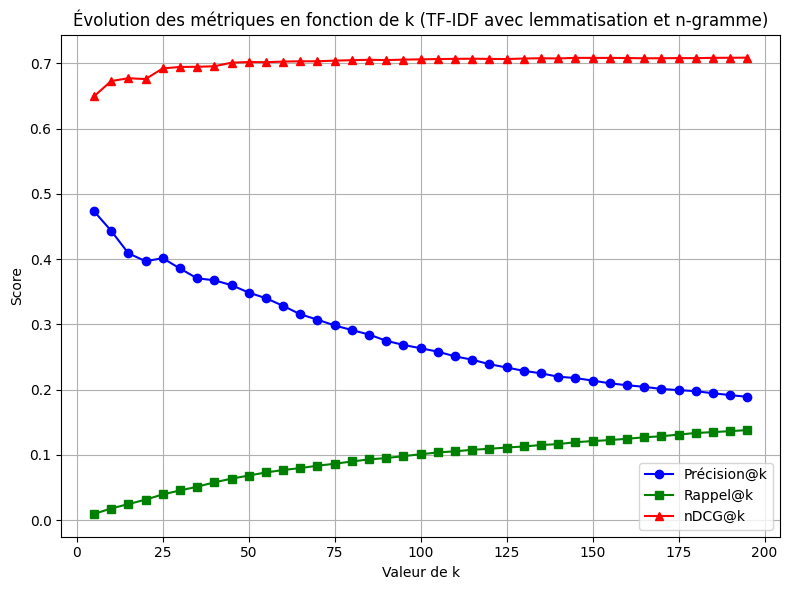

In [66]:
import matplotlib.pyplot as plt

# Supposons que tu as déjà ces listes
# ks, precision_scores, recall_scores, ndcg_scores

plt.figure(figsize=(8, 6))

# Tracer chaque courbe avec un marqueur et une couleur
plt.plot(ks, precision_scores, label='Précision@k', color='blue', marker='o')
plt.plot(ks, recall_scores, label='Rappel@k', color='green', marker='s')
plt.plot(ks, ndcg_scores, label='nDCG@k', color='red', marker='^')

# Ajouter les labels et titre
plt.xlabel('Valeur de k')
plt.ylabel('Score')
plt.title("Évolution des métriques en fonction de k (TF-IDF avec lemmatisation et n-gramme)")

# Ajouter une légende
plt.legend(loc='lower right')

# Ajouter une grille pour plus de lisibilité
plt.grid(True)

# Affichage
plt.tight_layout()
plt.show()


### Commentaire

Nous constatons qu'il n'y a pas vraiment une grande évolution malgré les valeurs de k que nous faisons varier 

#### Essayons de passer à un trigramme, faire du LSA pour capturer les relations semantiques latentes, personnalisation des poids (nous donnerons plus de poids aux titres qu'aux abstracts)

Car le but ici c'est qu'au moins le premier résultat soit toujours le meilleur, que les premiers documents retournés soient les meilleurs 

In [67]:
df_docs.head()

,doc_id,title,abstract
0,xqhn0vbp,Airborne rhinovirus detection and effect of ul...,"BACKGROUND: Rhinovirus, the most common cause ..."
1,gi6uaa83,Discovering human history from stomach bacteria,Recent analyses of human pathogens have reveal...
2,le0ogx1s,A new recruit for the army of the men of death,"The army of the men of death, in John Bunyan's..."
3,fy4w7xz8,Association of HLA class I with severe acute r...,BACKGROUND: The human leukocyte antigen (HLA) ...
4,0qaoam29,A double epidemic model for the SARS propagation,BACKGROUND: An epidemic of a Severe Acute Resp...


Ajout de plus de poids sur les titres 

In [74]:
# On donne 2x plus de poids au titre
documents_df["weighted_text"] = df_docs["title"].fillna("") * 2 + " " + df_docs["abstract"].fillna("")


Prétraitement avancé sur les nouvelles données : les titres ont plus de poids 

In [69]:
from tqdm import tqdm

tqdm.pandas()

# Nettoyage avec le prétraitement avancé (lemmatisation)
documents_df["processed_weighted_text"] = documents_df["weighted_text"].progress_apply(preprocess_advanced)


100%|██████████| 51078/51078 [36:30<00:00, 23.32it/s]  


Passons à la vectorisation en utilisant "processed_weighted_text" comme source 

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_weighted = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2,
    stop_words='english',
    max_features=30000
)

X_weighted_tfidf = vectorizer_weighted.fit_transform(documents_df["processed_weighted_text"])


Extraction des composantes semantiques principales dans les documents ainsi que dans les requêtes 

In [ ]:
from sklearn.decomposition import TruncatedSVD


# Nettoyage + lemmatisation 
queries_df["processed_query"] = queries_df["title"].fillna("").apply(preprocess_advanced)

# Vectorisation des requêtes avec le même vectorizer
queries_tfidf = vectorizer_weighted.transform(queries_df["processed_query"])

lsa = TruncatedSVD(n_components=3000, random_state=42)
X_lsa = lsa.fit_transform(X_weighted_tfidf)  # fit sur les documents
queries_lsa = lsa.transform(queries_tfidf)   # transform sur les requêtes



Fonction de recherche

In [ ]:
def search_weighted_lsa(query_text, top_k=10):
    """
    Recherche de documents avec TF-IDF + LSA + pondération du titre.
    Retourne doc_id, title, abstract, score.
    """
    # Prétraitement et vectorisation
    processed_query = preprocess_advanced(query_text)
    query_vec_tfidf = vectorizer_weighted.transform([processed_query])
    query_vec_lsa = lsa.transform(query_vec_tfidf)

    # Similarité cosinus avec les documents (déjà réduits)
    scores = cosine_similarity(query_vec_lsa, X_lsa).flatten()
    top_indices = scores.argsort()[::-1][:top_k]

    top_docs = documents_df.iloc[top_indices].copy()
    top_docs["title"] = top_docs["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    top_docs["abstract"] = top_docs["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))
    top_docs["score"] = scores[top_indices]

    return top_docs[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")


Faisons un test sur une requête et affichons le résultat

In [ ]:
# Exemple de requête
query = "origin of COVID-19"

# Recherche avec le moteur pondéré TF-IDF
results = search_weighted_lsa(query_text=query, top_k=10)

# Affichage des résultats
display_search_results(results, query)


,doc_id,score,title,abstract
0,gv1k7u7j,0.699698,Strategies to trace back the origin of COVID-19,Strategies to trace back the origin of COVID-19
1,jphbdxhw,0.644856,Early life origins of asthma,Early life origins of asthma
2,80e5xkht,0.547729,Reacting to the emergence of swine-origin influenza A H1N1,Reacting to the emergence of swine-origin influenza A H1N1
3,73xil5op,0.534396,Bat origin of a new human coronavirus: there and back again,Bat origin of a new human coronavirus: there and back again
4,49360l2a,0.512495,A phylogenomic data-driven exploration of viral origins and evolutionThe origin of viruses remains mysterious because of their diverse and patchy molecular and functional makeup,"Although numerous hypotheses have attempted to explain viral origins, none is backed by substantive data. We take full advantage of the wealth of available protein structural and functional data to explore the evolution of the proteomic makeup of thousands of cells and viruses. Despite the extremely reduced nature of viral proteomes, we established an ancient origin of the “viral supergroup” and the existence of widespread episodes of horizontal transfer of genetic information. Viruses harboring different replicon types and infecting distantly related hosts shared many metabolic and informational protein structural domains of ancient origin that were also widespread in cellular proteomes. Phylogenomic analysis uncovered a universal tree of life and revealed that modern viruses reduced from multiple ancient cells that harbored segmented RNA genomes and coexisted with the ancestors of modern cells. The model for the origin and evolution of viruses and cells is backed by strong genomic and structural evidence and can be reconciled with existing models of viral evolution if one considers viruses to have originated from ancient cells and not from modern counterparts."
5,vp5358rr,0.508130,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME
6,vp5358rr,0.508130,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME
7,ycvu5l5f,0.496270,A glimpse into the origins of genetic diversity in SARS-CoV-2,A glimpse into the origins of genetic diversity in SARS-CoV-2
8,mcj078if,0.467524,"Retinal degenerations of hereditary, viral and autoimmune origins: Studies on opsin and IRBP","Retinal degenerations of hereditary, viral and autoimmune origins: Studies on opsin and IRBP"
9,9dj07sac,0.464838,"The prevalence, origin, and prevention of six human coronaviruses[Image: see text]","The prevalence, origin, and prevention of six human coronaviruses[Image: see text]"


Evaluons le nouveau modèle 

In [ ]:
results_lsa = evaluate_model(search_weighted_lsa, queries_df, qrels_df, k=10)

print("Résultats du moteur TF-IDF pondéré avec LSA :")
for metric, score in results_lsa.items():
    print(f"- {metric}: {score:.4f}")


Résultats du moteur TF-IDF pondéré avec LSA :
- precision@k: 0.4367
- recall@k: 0.0173
- F1@k: 0.0332
- MRR: 0.6104
- nDCG@k: 0.6894
- MAP: 0.0129


Les scores des métriques ne sont pas meilleures que les précédentes (du moins TFIDF avec nettoyages avancés). La semantique latente extraite n'a pa été d'une très grande aide

 On va donc se concentrer sur la version sans LSA, avec les améliorations suivantes déjà intégrées :

- Nettoyage avancé + lemmatisation via spaCy

- Dictionnaire enrichi de synonymes adapté au domaine médical

- TF-IDF avec n-grammes (1,2)

- Pondération du titre

- Évaluation avec précision, rappel, F1, MRR, nDCG

- Fonction d’affichage avec surlignage des mots-clés

On va utiliser cela comme notre modèle de base et passer à autre chose (modèle )

## PRF avec tfidf sans LSA 

Nous allons à présent utiliser le modèle tfidf avec nettoyage avancé pour faire du PRF (Pseudo Relevance Feedback)

Fonction pour extraire les top_n termes : qu'on utilisera dans les premiers retours des documents pour une requête 

In [78]:
from collections import Counter

def extract_top_terms(documents, top_n=5):
    """
    Extrait les top_n termes les plus fréquents des documents (déjà prétraités).
    """
    all_tokens = " ".join(documents["processed_text"]).split()
    most_common = Counter(all_tokens).most_common(top_n)
    return [term for term, _ in most_common]


Fonction de recherche avec PRF

In [79]:
def search_with_prf(query_text, top_k=10, feedback_docs=5, feedback_terms=5):
    # Étape 1 : recherche initiale
    initial_results = search_tfidf(query_text, top_k=feedback_docs)
    feedback_doc_ids = [res["doc_id"] for res in initial_results]

    # Récupération des textes prétraités de ces documents
    feedback_docs_df = documents_df[documents_df["doc_id"].isin(feedback_doc_ids)]
    top_terms = extract_top_terms(feedback_docs_df, top_n=feedback_terms)

    # Étape 2 : enrichissement de la requête
    enriched_query = query_text + " " + " ".join(top_terms)

    # Étape 3 : nouvelle recherche
    return search_tfidf(enriched_query, top_k=top_k)


Exemple d'utilisation sur une requête

In [80]:
# Requête test
query = "origin of covid-19"

# Résultats enrichis par PRF
results = search_with_prf(query_text=query, top_k=10, feedback_docs=5, feedback_terms=5)

display_search_results(results, query)


,doc_id,score,title,abstract
0,vp5358rr,0.919084,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME
1,vp5358rr,0.919084,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME,PARENTAL ORIGIN OF CHROMOSOME 15 DELETION IN PRADER-WILLI SYNDROME
2,3onooc4v,0.385588,Chromosomes and expression mechanisms,Chromosomes and expression mechanisms
3,1uy405i3,0.385588,Chromosomes and expression mechanisms,Chromosomes and expression mechanisms
4,rda1k81w,0.385588,Chromosomes and expression mechanisms,Chromosomes and expression mechanisms
5,gv1k7u7j,0.371808,Strategies to trace back the origin of COVID-19,Strategies to trace back the origin of COVID-19
6,9dj07sac,0.314148,"The prevalence, origin, and prevention of six human coronaviruses[Image: see text]","The prevalence, origin, and prevention of six human coronaviruses[Image: see text]"
7,ycvu5l5f,0.305803,A glimpse into the origins of genetic diversity in SARS-CoV-2,A glimpse into the origins of genetic diversity in SARS-CoV-2
8,gyj5213f,0.270702,"Origins of MERS-CoV, and lessons for 2019-nCoV","Origins of MERS-CoV, and lessons for 2019-nCoV"
9,jphbdxhw,0.267240,Early life origins of asthma,Early life origins of asthma


Evaluation

In [81]:
results_prf = evaluate_model(search_with_prf, queries_df, qrels_df, k=10)

for metric, score in results_prf.items():
    print(f"- {metric}: {score:.4f}")


- precision@k: 0.4367
- recall@k: 0.0178
- F1@k: 0.0342
- MRR: 0.6270
- nDCG@k: 0.6379
- MAP: 0.0149


### Commentaire 

Avec PRF on perd entièrement en pertinence sur les premiers résultats retournés, les termes qu'on récupère pour rencherir la requête n'est pas toujours assez pour contextualiser. Nous allons passer à un modèle avancé en gardant notre modèle tfidf sans LSA et sans ngramme comme modèle de base.

Ce modèle de base a donné les résultats suivants comme évaluation:

**Résultats du modèle TF-IDF avec prétraitement avancé** :
- precision@k: 0.2573
- recall@k: 0.0978
- F1@k: 0.1406
- MRR: 0.6958
- nDCG@k: 0.7480
- MAP: 0.0568

Ceci est le modèle que nous retenons comme modèle de base 

### SBERT (Sentence-BERT)

Nous allons passer à ce modèle avancé qui lui capte plus de semantique dans les termes nous verrons si cela est plus performant que notre modèle de ba

In [82]:
!pip install -U sentence-transformers



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\12407156\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Chargement du modèle à utiliser pour encoder les documents et les requêtes

In [6]:
from sentence_transformers import SentenceTransformer


model_sbert = SentenceTransformer('all-MiniLM-L6-v2')  


W0826 09:55:32.774000 7804 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
C:\Users\stginrae.AFRIQUE-TP02\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#### Encodage des documents prétraités 

Nous allons former les embeddings de nos documents 

In [10]:
documents_df = pd.read_csv("./api/documents_cleaned.csv")

In [11]:
doc_embeddings = model_sbert.encode(documents_df["processed_text"].tolist(), show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/1597 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Fonction de recherche avec S-BERT, 

Nous allons encoder les requêtes dans cette fonction puis calculer le score de similarité entre les embeddings des documents et ceux des requêtes 

In [86]:
def search_sbert(query_text, top_k=10):
    query_embedding = model_sbert.encode(query_text, convert_to_tensor=True)
    similarities = cosine_similarity(query_embedding.cpu().numpy().reshape(1, -1), doc_embeddings.cpu().numpy()).flatten()
    top_indices = similarities.argsort()[::-1][:top_k]
    
    top_docs = documents_df.iloc[top_indices].copy()
    top_docs["score"] = similarities[top_indices]
    top_docs["title"] = top_docs["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    top_docs["abstract"] = top_docs["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))

    return top_docs[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")


Application sur une requête 

In [87]:
# Requête test
query = "origin of covid-19"

# Résultats enrichis par PRF
results = search_sbert(query, top_k=10)

display_search_results(results, query)


,doc_id,score,title,abstract
0,34e5054s,0.553586,The emergence of a new corona virus—MERS-CoV: Hind sight is always 20/20,The emergence of a new corona virus—MERS-CoV: Hind sight is always 20/20
1,73xil5op,0.544710,Bat origin of a new human coronavirus: there and back again,Bat origin of a new human coronavirus: there and back again
2,ne5r4d4b,0.544477,Origin and evolution of pathogenic coronavirusesSevere acute respiratory syndrome coronavirus (SARS-CoV) and Middle East respiratory syndrome coronavirus (MERS-CoV) are two highly transmissible and pathogenic viruses that emerged in humans at the beginning of the 21st century,"Both viruses likely originated in bats, and genetically diverse coronaviruses that are related to SARS-CoV and MERS-CoV were discovered in bats worldwide. In this Review, we summarize the current knowledge on the origin and evolution of these two pathogenic coronaviruses and discuss their receptor usage; we also highlight the diversity and potential of spillover of bat-borne coronaviruses, as evidenced by the recent spillover of swine acute diarrhoea syndrome coronavirus (SADS-CoV) to pigs."
3,k1yknsgf,0.538876,Coronavirus motif,Coronavirus motif
4,kh21pnbw,0.532307,New coronavirus,New coronavirus
5,yymzeor9,0.526167,NOVEL CORONAVIRUS THAT RECENTLY EMERGED IN CHINA,NOVEL CORONAVIRUS THAT RECENTLY EMERGED IN CHINA
6,spwtwcy5,0.519928,The genomes of three coronaviruses,The genomes of three coronaviruses
7,7v22eib4,0.518679,A Contemporary View of Coronavirus Transcription,A Contemporary View of Coronavirus Transcription
8,2twiejju,0.516137,Human coronaviruses,Human coronaviruses
9,3svqyeml,0.516137,222 Human Coronaviruses,222 Human Coronaviruses


#### Evaluation du moteur S-BERT 

In [88]:
results_sbert = evaluate_model(search_sbert, queries_df, qrels_df, k=10)

for metric, score in results_sbert.items():
    print(f"- {metric}: {score:.4f}")


- precision@k: 0.0933
- recall@k: 0.0037
- F1@k: 0.0070
- MRR: 0.3665
- nDCG@k: 0.3931
- MAP: 0.0023


#### Commentaire

Ce modèle ne performe pas bien avec ces documents pour plusieurs raisons : 

**Corpus spécialisé (domaine médical)**
- SBERT est entraîné sur des données générales (Wikipedia, Reddit, etc.). Il comprend mal les subtilités du domaine biomédical comme les termes spécialisés, acronymes ou synonymes complexes.

**Manque d’adaptation à la tâche**
- SBERT n’a pas été fine-tuné sur une tâche de retrieval biomédical (contrairement à des modèles comme BioBERT, SciBERT, ou SapBERT).

**Prétraitement différent**
- SBERT est souvent plus efficace sans trop de nettoyage, car le modèle a été entraîné sur des phrases entières naturelles. Trop de nettoyage (lemmatisation, suppression) peut nuire à ses performances.



### Nous allons essayer de repartir sur des données qui n'ont pas subit de prétraitement avancés comme nous l'avons fait plus haut nous allons également utiliser un modèle SciBERT qui est adapté aux documents scientifiques

In [ ]:
df_docs["full_text"] = df_docs["title"].fillna("") + ". " + df_docs["abstract"].fillna("")

In [ ]:
doc_embeddings_none_preprocess = model_sbert.encode(df_docs["full_text"].tolist(), show_progress_bar=True, convert_to_tensor=True)

Batches: 100%|██████████| 1597/1597 [26:05<00:00,  1.02it/s] 


Fonction de recherche SBERT sans prétraitement sur les documents 

Nous allons encoder les requêtes dans la fonction 

In [ ]:
def search_sbert_no_preprocess(query_text, top_k=10):
    query_embedding = model_sbert.encode(query_text, convert_to_tensor=True)
    similarities = cosine_similarity(query_embedding.cpu().numpy().reshape(1, -1), doc_embeddings_none_preprocess.cpu().numpy()).flatten() # Utilions doc_embeddings_none_preprocess
    top_indices = similarities.argsort()[::-1][:top_k]
    
    top_docs = documents_df.iloc[top_indices].copy()
    top_docs["score"] = similarities[top_indices]
    top_docs["title"] = top_docs["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    top_docs["abstract"] = top_docs["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))

    return top_docs[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")


Application à une requête

In [ ]:
# Requête test
query = "origin of covid-19"

# Résultats enrichis par PRF
results = search_sbert_no_preprocess(query, top_k=10)

display_search_results(results, query)


,doc_id,score,title,abstract
0,34e5054s,0.553586,The emergence of a new corona virus—MERS-CoV: Hind sight is always 20/20,The emergence of a new corona virus—MERS-CoV: Hind sight is always 20/20
1,73xil5op,0.544710,Bat origin of a new human coronavirus: there and back again,Bat origin of a new human coronavirus: there and back again
2,ne5r4d4b,0.544477,Origin and evolution of pathogenic coronavirusesSevere acute respiratory syndrome coronavirus (SARS-CoV) and Middle East respiratory syndrome coronavirus (MERS-CoV) are two highly transmissible and pathogenic viruses that emerged in humans at the beginning of the 21st century,"Both viruses likely originated in bats, and genetically diverse coronaviruses that are related to SARS-CoV and MERS-CoV were discovered in bats worldwide. In this Review, we summarize the current knowledge on the origin and evolution of these two pathogenic coronaviruses and discuss their receptor usage; we also highlight the diversity and potential of spillover of bat-borne coronaviruses, as evidenced by the recent spillover of swine acute diarrhoea syndrome coronavirus (SADS-CoV) to pigs."
3,k1yknsgf,0.538876,Coronavirus motif,Coronavirus motif
4,kh21pnbw,0.532307,New coronavirus,New coronavirus
5,yymzeor9,0.526167,NOVEL CORONAVIRUS THAT RECENTLY EMERGED IN CHINA,NOVEL CORONAVIRUS THAT RECENTLY EMERGED IN CHINA
6,spwtwcy5,0.519928,The genomes of three coronaviruses,The genomes of three coronaviruses
7,7v22eib4,0.518679,A Contemporary View of Coronavirus Transcription,A Contemporary View of Coronavirus Transcription
8,2twiejju,0.516137,Human coronaviruses,Human coronaviruses
9,3svqyeml,0.516137,222 Human Coronaviruses,222 Human Coronaviruses


#### Evaluation de SBERT sur les données non nettoyées 

In [ ]:
results_sbert = evaluate_model(search_sbert_no_preprocess, queries_df, qrels_df, k=10)

print("Score de SBERT sur TREC-COVID brut")
for metric, score in results_sbert.items():
    print(f"- {metric}: {score:.4f}")


- precision@k: 0.0933
- recall@k: 0.0037
- F1@k: 0.0070
- MRR: 0.3665
- nDCG@k: 0.3931
- MAP: 0.0023


#### SBERT n'est pas spécialisé pour les documents scientifiques, nous allons donc utiliser SciBERT qui est un modèle préentrainé sur les documents scientifiques 

### SciBERT est utilisé sur les données brutes, pas de prétraitements car ce modèle comporte déjà un tokenizer puissant

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

tokenizer_sci = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model_sci = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

# Fonction pour générer l'embedding moyen
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # (batch_size, seq_len, hidden_size)
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
    return (token_embeddings * input_mask_expanded).sum(1) / input_mask_expanded.sum(1)

# Préparation des embeddings (à faire une fois)
with torch.no_grad():
    doc_embeddings_sci = []
    for text in documents_df["text"]:
        inputs = tokenizer_sci(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = model_sci(**inputs)
        emb = mean_pooling(outputs, inputs["attention_mask"])
        doc_embeddings_sci.append(emb.squeeze(0))
    doc_embeddings_sci = torch.stack(doc_embeddings_sci)

def search_scibert(query_text, top_k=10):
    with torch.no_grad():
        inputs = tokenizer_sci(query_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = model_sci(**inputs)
        query_embedding = mean_pooling(outputs, inputs["attention_mask"]).cpu().numpy()
    
    similarities = cosine_similarity(query_embedding.reshape(1, -1), doc_embeddings_sci.cpu().numpy()).flatten()
    top_indices = similarities.argsort()[::-1][:top_k]

    top_docs = documents_df.iloc[top_indices].copy()
    top_docs["score"] = similarities[top_indices]
    top_docs["title"] = top_docs["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    top_docs["abstract"] = top_docs["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))

    return top_docs[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")


## Problème avec ce modèle

Ce modèle nécessite énormément de ressources, nous n'avons pas pu terminer son entrainement, nous allons tout de même mettre le script pour la suite comme on le faisait avec les modèles précédents, 

#### Exemple sur une requête 

In [ ]:
# Requête test
query = "origin of covid-19"

# Résultats enrichis par PRF
results = search_scibert(query, top_k=10)

display_search_results(results, query)


#### Evaluation du modèle SciBERT 

In [ ]:
results_scibert = evaluate_model(search_scibert, queries_df, qrels_df, k=10)
print("Evaluation du modèle SciBERT")
for metric, score in results_sbert.items():
    print(f"- {metric}: {score:.4f}")


### Explorons également le modèle probabiliste d'état de l'art BM25 

Ce modèle doit être utilisé sur les données prétraitées, nous allons donc utiliser la colonne de preprocessed_text

Nous allons construire encore les embeddings pour les documents nettoyés 

In [ ]:
## Nous les avions déjà dans "doc_embeddings" donc nous allons simplement l'utiliser dans la fonction de recherche avec "search_BM25"

In [90]:
!pip install rank-bm25



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\12407156\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Un dictionnaire pour enrichir le vocabulaire car bm25 ne tient pas compte de la semantique

In [101]:
synonym_dict = {
    "covid": ["covid-19", "coronavirus", "sars-cov-2", "sars cov 2", "ncov", "2019-ncov"],
    "origin": ["source", "emergence", "evolution", "beginning", "birth"],
    "pandemic": ["outbreak", "epidemic", "global health crisis"],
    "vaccine": ["vaccination", "immunization", "injection"],
    "transmission": ["spread", "contagion", "infection path", "propagation"],
    "face mask": ["mask", "surgical mask", "protective mask", "n95"],
    "lockdown": ["shutdown", "quarantine", "confinement", "isolation"],
    "hospital": ["clinic", "medical center", "health facility"],
    "test": ["diagnostic", "screening", "pcr", "swab"],
    "treatment": ["therapy", "medication", "drug", "remedy", "intervention"],
    "symptom": ["sign", "clinical sign", "manifestation"],
    "respiratory": ["breathing", "lung", "pulmonary", "airway"],
    "healthcare": ["medical care", "health system", "hospital system"],
    "death": ["mortality", "fatality", "loss of life"],
    "prevention": ["protection", "avoidance", "barrier", "control measures"],
    "mutation": ["variant", "strain", "genetic change", "genomic shift"],
    "children": ["kids", "infants", "minors", "young people"],
    "elderly": ["older adults", "seniors", "aged population", "geriatrics"],
    "vulnerable": ["at-risk", "immunocompromised", "fragile", "susceptible"],
    "public health": ["population health", "community health", "health policy"]
}



## Fonction pour l'utiliser 
def enrich_with_synonyms(text, synonym_dict):
    text = text.lower()
    for key, synonyms in synonym_dict.items():
        for synonym in synonyms:
            if synonym in text:
                text = text.replace(synonym, key)
    return text


### Prétraitement adapté pour le modèle probabiliste bm25 avec vocabulaire enrichi

In [102]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_bm25(text):
    text = enrich_with_synonyms(text, synonym_dict)
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and token.isalnum()
    ]
    return tokens



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12407156\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12407156\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12407156\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Application sur les documents une seule fois et construction de la fonction pour la recherche

In [103]:
from rank_bm25 import BM25Okapi

# Tokeniser + nettoyer tous les documents une seule fois :
tokenized_corpus = [preprocess_bm25(doc) for doc in documents_df["text"]]

# Créer le modèle BM25
bm25 = BM25Okapi(tokenized_corpus)

def search_bm25(query_text, top_k=10):
    tokenized_query = preprocess_bm25(query_text)
    scores = bm25.get_scores(tokenized_query)

    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
    top_docs = documents_df.iloc[top_indices].copy()
    top_docs["score"] = [scores[i] for i in top_indices]
    top_docs["title"] = top_docs["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    top_docs["abstract"] = top_docs["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))

    return top_docs[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")

#### Exemple sur une requête 

In [104]:
# Requête test
query = "origin of covid-19"

# Résultats enrichis par PRF
results = search_bm25(query, top_k=10)

display_search_results(results, query)


,doc_id,score,title,abstract
0,h8abjsxr,7.291247,新型冠状病毒SARS-CoV-2的变异和进化分析OBJECTIVE: To analyze the evolution and variation of SARS-CoV-2 during the epidemic starting at the end of 2019,"METHODS: We downloaded the full-length genome sequence of SARS-CoV-2 from the databases of GISAID and NCBI. Using the software for bioinformatics including MEGA-X, BEAST, and TempEst, we constructed the genomic evolution tree, inferred the time evolution signal of the virus, calculated the tMRCA time of the virus and analyzed the selection pressure of the virus during evolution. RESULTS: The phylogenetic tree showed that SARS-CoV-2 belonged to the Sarbecovirus subgenus of β Coronavirus genus together with bat coronavirus BetaCoV/bat/Yunnan/RaTG13/2013, bat-SL-CoVZC45, bat-SL-CoVZXC21 and SARS-CoV. The genomic sequences of SARS-CoV-2 isolated from the ongoing epidemic showed a weak time evolution signal with an average tMRCA time of 73 days (95% CI: 38.9-119.3 days). No positive time evolution signal was found between SARS-CoV-2 and BetaCoV/bat/Yunnan/RaTG13/2013, but the former virus had a strong positive temporal evolution relationship with bat-SL-CoVZC45 and SARS-CoV. The major cause for mutations of SARS-CoV-2 was the pressure of purification selection during the epidemic. CONCLUSION: SARS-CoV-2 may have emerged as early as November, 2019, originating most likely from bat-associated coronavirus. This finding may provide evidence for tracing the sources and evolution of the virus."
1,ne5r4d4b,6.778319,Origin and evolution of pathogenic coronavirusesSevere acute respiratory syndrome coronavirus (SARS-CoV) and Middle East respiratory syndrome coronavirus (MERS-CoV) are two highly transmissible and pathogenic viruses that emerged in humans at the beginning of the 21st century,"Both viruses likely originated in bats, and genetically diverse coronaviruses that are related to SARS-CoV and MERS-CoV were discovered in bats worldwide. In this Review, we summarize the current knowledge on the origin and evolution of these two pathogenic coronaviruses and discuss their receptor usage; we also highlight the diversity and potential of spillover of bat-borne coronaviruses, as evidenced by the recent spillover of swine acute diarrhoea syndrome coronavirus (SADS-CoV) to pigs."
2,h2uc7ria,6.709783,"Evolutionary origins of the SARS-CoV-2 sarbecovirus lineage responsible for the COVID-19 pandemicThere are outstanding evolutionary questions on the recent emergence of coronavirus SARS-CoV-2/hCoV-19 in Hubei province that caused the COVID-19 pandemic, including (1) the relationship of the new virus to the SARS-related coronaviruses, (2) the role of bats as a reservoir species, (3) the potential role of other mammals in the emergence event, and (4) the role of recombination in viral emergence","Here, we address these questions and find that the sarbecoviruses -- the viral subgenus responsible for the emergence of SARS-CoV and SARS-CoV-2 -- exhibit frequent recombination, but the SARS-CoV-2 lineage itself is not a recombinant of any viruses detected to date. In order to employ phylogenetic methods to date the divergence events between SARS-CoV-2 and the bat sarbecovirus reservoir, recombinant regions of a 68-genome sarbecovirus alignment were removed with three independent methods. Bayesian evolutionary rate and divergence date estimates were consistent for all three recombination-free alignments and robust to two different prior specifications based on HCoV-OC43 and MERS-CoV evolutionary rates. Divergence dates between SARS-CoV-2 and the bat sarbecovirus reservoir were estimated as 1948 (95% HPD: 1879-1999), 1969 (95% HPD: 1930-2000), and 1982 (95% HPD: 1948-2009). Despite intensified characterization of sarbecoviruses since SARS, the lineage giving rise to SARS-CoV-2 has been circulating unnoticed for decades in bats and been transmitted to other hosts such as pangolins. The occurrence of a third significant coronavirus emergence in 17 years together with the high

### Remarque
Nous constatons que les scores de bm25 ne se situent pas entre 0 et 1. D'après nos recherches, le score de bm25 se situe généralement entre [0,15] ou [0,25]

#### Evaluation du modèle BM25

In [105]:
results_bm25 = evaluate_model(search_bm25, queries_df, qrels_df, k=10)
print("Evaluation du modèle BM25")
for metric, score in results_bm25.items():
    print(f"- {metric}: {score:.4f}")


Evaluation du modèle BM25
- precision@k: 0.7333
- recall@k: 0.0276
- F1@k: 0.0530
- MRR: 0.9344
- nDCG@k: 0.9353
- MAP: 0.0254


### Commentaire

Nous constatons un score bien plus grand que dans les travaux précédents pour ce modèle avancé, pour k=10, nous avons un score de 73% pour la précision, 93% pour le Mean Reciprocal Rank (le premier document est à 93% le document pertinent pour ces requêtes), 93% pour le nDCG (dans les 10 documents retournés, 93% sont pertinents pour les requêtes utilisées). Mais le rappel n'est pas encore très bon ici, c'est la raison pour laquelle nous allons effectuer le graphe afin de voir l'évolution de ces scores en fonction de k 

### Graphe d'évolution des scores en fonction de k avec bm25 

In [106]:
ks = list(range(5, 200, 5))
precision_scores = []
recall_scores = []
ndcg_scores = []
f1_score = []
mrr_score = []
map_score = []

for k in ks:
    results = evaluate_model(search_bm25, queries_df, qrels_df, k=k)
    precision_scores.append(results["precision@k"])
    recall_scores.append(results["recall@k"])
    ndcg_scores.append(results['nDCG@k'])
    f1_score.append(results["F1@k"])
    mrr_score.append(results["MRR"])
    map_score.append(results["MAP"])


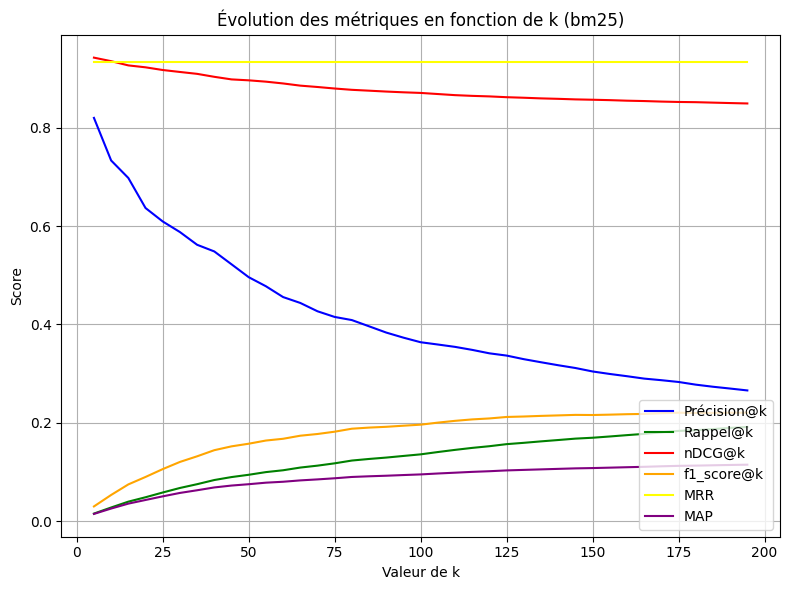

In [ ]:
import matplotlib.pyplot as plt

# Supposons que tu as déjà ces listes
# ks, precision_scores, recall_scores, ndcg_scores

plt.figure(figsize=(8, 6))

# Tracer chaque courbe avec un marqueur et une couleur
plt.plot(ks, precision_scores, label='Précision@k', color='blue')
plt.plot(ks, recall_scores, label='Rappel@k', color='green')
plt.plot(ks, ndcg_scores, label='nDCG@k', color='red')
plt.plot(ks,f1_score, label='f1_score@k', color='orange' )
plt.plot(ks, mrr_score, label='MRR', color='yellow')
plt.plot(ks, map_score, label='MAP', color='purple')

# Ajouter les labels et titre
plt.xlabel('Valeur de k')
plt.ylabel('Score')
plt.title("Évolution des métriques en fonction de k (bm25)")

# Ajouter une légende
plt.legend(loc='lower right')

# Ajouter une grille pour plus de lisibilité
plt.grid(True)

# Affichage
plt.tight_layout()
plt.show()


### Commentaire

Le rappel ne veut pas avancer dans ce projet, il n'y a pas assez de documents pertinents pour les requêtes, nous pensons que c'est mieux de suivre le f1-score au lieu de suivre le rappel et la precision séparé. D'après le graphe, le MRR reste pareil, le ndcg semble regresser avant de devenir stable, mais à k=50, nous pouvons conclure

In [108]:
results_bm25 = evaluate_model(search_bm25, queries_df, qrels_df, k=50)
print("Evaluation du modèle BM25")
for metric, score in results_bm25.items():
    print(f"- {metric}: {score:.4f}")


Evaluation du modèle BM25
- precision@k: 0.4960
- recall@k: 0.0941
- F1@k: 0.1573
- MRR: 0.9344
- nDCG@k: 0.8964
- MAP: 0.0749


### Explorons aussi MTMBM25 qui a donné le plus grand score pour les chercheurs en 2020 durant le challenge 

In [109]:
from sklearn.metrics.pairwise import cosine_similarity

def search_mtmbm25(query_text, top_k=10, alpha=0.5):
    # alpha : poids SBERT (0.5 = moyenne avec BM25)
    query_embedding = model_sbert.encode(query_text, convert_to_tensor=True)
    similarities_sbert = cosine_similarity(query_embedding.cpu().numpy().reshape(1, -1), doc_embeddings.cpu().numpy()).flatten()

    tokenized_query = word_tokenize(query_text.lower())
    scores_bm25 = bm25.get_scores(tokenized_query)

    final_scores = alpha * similarities_sbert + (1 - alpha) * scores_bm25
    top_indices = final_scores.argsort()[::-1][:top_k]

    top_docs = documents_df.iloc[top_indices].copy()
    top_docs["score"] = final_scores[top_indices]
    top_docs["title"] = top_docs["text"].apply(lambda t: t.split(". ")[0] if ". " in t else t[:100])
    top_docs["abstract"] = top_docs["text"].apply(lambda t: t if ". " not in t else ". ".join(t.split(". ")[1:]))

    return top_docs[["doc_id", "title", "abstract", "score"]].to_dict(orient="records")


#### Exemple sur une requête 

In [110]:
# Requête test
query = "origin of covid-19"

# Résultats enrichis par PRF
results = search_mtmbm25(query, top_k=10)

display_search_results(results, query)


,doc_id,score,title,abstract
0,gy8d8285,2.472703,"The Origin and Evolution of VirusesThe lecture covers three main topics: (i) Viruses: properties, pl","The Origin and Evolution of VirusesThe lecture covers three main topics: (i) Viruses: properties, place in the living world, and possible origin; (ii) Molecular basis of viral variability and evolution; and (iii) Evolution of viral pathogenicity and emerging viral infections."
1,01a8er2v,2.414081,Evolution of VirusesThe study of virus evolution has historically been concerned with disease and its emergence and has not been integrated into the general study of evolution,"Yet viruses dominate our planet and their evolution is a broad and applied field that can be studied in the real time (such HIV in human disease) and can also be applied to biotechnological problems. Virus evolution is very similar, but not identical, to host evolution. Darwinian principles apply, such as with Fisher population genetics, but other features, such as reticulated and quasispecies-based evolution, distinguish virus evolution. In RNA viruses, high error rates have led to the quasispecies concept in which collective populations are the basis of evolution. These populations provide viruses with high capacities for adaptation. Yet some RNA viruses show remarkable evolutionary stability. With DNA viruses, especially of bacteria, extensive recombination defines vast dynamic and ancient genetic pools. Temperate viruses can directly affect host gene pools by stable colonization. DNA viruses can be genetically complex and have evolved many unique viral genes. The retroviruses show both quasispecies-based rapid evolution and host-linked slow coevolution (e.g., endogenous retroviruses). Thus, virus evolution impacts all life and viral emergence continues to threaten human health."
2,p0kv1pht,2.408460,"Phylogenetic perspectives on the epidemiology and origins of SARS and SARS-like coronavirusesAbstract Severe Acute Respiratory Syndrome (SARS) is a respiratory disease caused by a zoonotic coronavirus (CoV) named SARS-CoV (SCoV), which rapidly swept the globe after its emergence in rural China during late 2002","The origins of SCoV have been mysterious and controversial, until the recent discovery of SARS-like CoV (SLCoV) in bats and the proposal of bats as the natural reservior of the Coronaviridae family. In this article, we focused on discussing how phylogenetics contributed to our understanding towards the emergence and transmission of SCoV. We first reviewed the epidemiology of SCoV from a phylogenetic perspective and discussed the controversies over its phylogenetic origins. Then, we summarized the phylogenetic findings in relation to its zoonotic origins and the proposed inter-species viral transmission events. Finally, we also discussed how the discoveries of SCoV and SLCoV expanded our knowledge on the evolution of the Coronaviridae family as well as its implications on the possible future re-emergence of SCoV."
3,ne5r4d4b,2.401794,Origin and evolution of pathogenic coronavirusesSevere acute respiratory syndrome coronavirus (SARS-CoV) and Middle East respiratory syndrome coronavirus (MERS-CoV) are two highly transmissible and pathogenic viruses that emerged in humans at the beginning of the 21st century,"Both viruses likely originated in bats, and genetically diverse coronaviruses that are related to SARS-CoV and MERS-CoV were discovered in bats worldwide. In this Review, we summarize the current knowledge on the origin and evolution of these two pathogenic coronaviruses and discuss their receptor usage; we also highlight the diversity and potential of spillover of bat-borne coronaviruses, as evidenced by the recent spillover of swine acute diarrhoea syndrome coronavirus (SADS-CoV) to pigs."
4,7hw23xae,2.367070,Deciphering MERS-CoV Evolution in Dromedary CamelsThe emergence of the Middle East respiratory syndrome coronavirus (MERS-CoV) poses a potential threat to global public health,Many aspects of the

#### Evaluation du modèle MTMBM25

In [116]:
results_mtmbm25 = evaluate_model(search_mtmbm25, queries_df, qrels_df, k=50)
print("Evaluation du modèle MTMBM25")
for metric, score in results_mtmbm25.items():
    print(f"- {metric}: {score:.4f}")


Evaluation du modèle MTMBM25
- precision@k: 0.3253
- recall@k: 0.0648
- F1@k: 0.1074
- MRR: 0.7054
- nDCG@k: 0.7169
- MAP: 0.0469


### Commentaire,
Nous constatons également un bon score de ce côté, mais le modèle bm25 reste tout de même meilleur parmi tous les modèles que nous avons fait jusqu'ici, le modèle SciBERT nécessite plus d'espace pour sa mise en place nous n'avons pas pu le faire.

Ainsi, nous allons conserver le modèle bm25 pour concevoir notre application

### Graphe d'évolution des scores en fonction de k avec MTMBM25

In [112]:
ks = list(range(5, 200, 5))
precision_scores = []
recall_scores = []
ndcg_scores = []
f1_score = []
mrr_score = []
map_score = []

for k in ks:
    results = evaluate_model(search_mtmbm25, queries_df, qrels_df, k=k)
    precision_scores.append(results["precision@k"])
    recall_scores.append(results["recall@k"])
    ndcg_scores.append(results['nDCG@k'])
    f1_score.append(results["F1@k"])
    mrr_score.append(results["MRR"])
    map_score.append(results["MAP"])


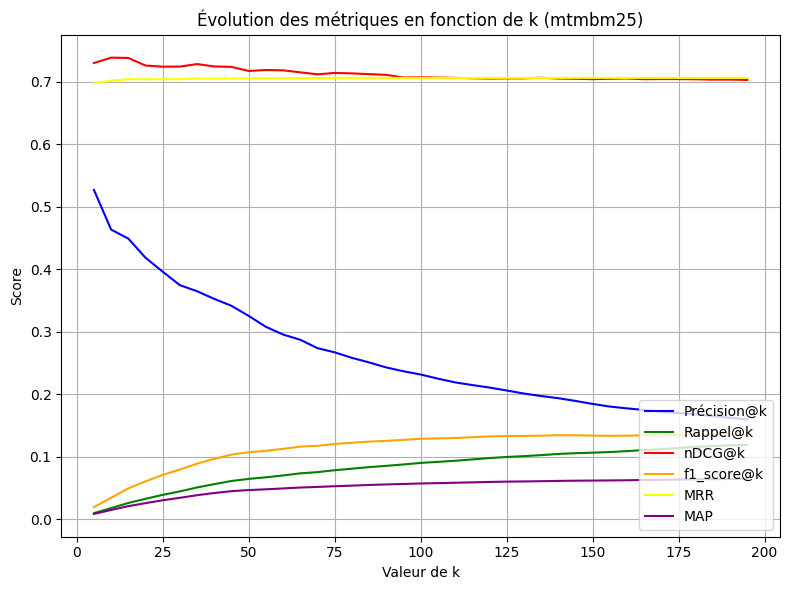

In [115]:
import matplotlib.pyplot as plt

# Supposons que tu as déjà ces listes
# ks, precision_scores, recall_scores, ndcg_scores

plt.figure(figsize=(8, 6))

# Tracer chaque courbe avec un marqueur et une couleur
plt.plot(ks, precision_scores, label='Précision@k', color='blue')
plt.plot(ks, recall_scores, label='Rappel@k', color='green')
plt.plot(ks, ndcg_scores, label='nDCG@k', color='red')
plt.plot(ks,f1_score, label='f1_score@k', color='orange' )
plt.plot(ks, mrr_score, label='MRR', color='yellow')
plt.plot(ks, map_score, label='MAP', color='purple')

# Ajouter les labels et titre
plt.xlabel('Valeur de k')
plt.ylabel('Score')
plt.title("Évolution des métriques en fonction de k (mtmbm25)")

# Ajouter une légende
plt.legend(loc='lower right')

# Ajouter une grille pour plus de lisibilité
plt.grid(True)

# Affichage
plt.tight_layout()
plt.show()


### Sauvegarde du modèle qui a donné le plus grand score afin de concevoir l'API 

### Sauvegarde des objets avec pickle

Nous avons sauvegardés les données néttoyées et les embeddings pour mettre en place l'application

In [114]:
import pickle

# Sauvegarde du modèle bm25 + documents
with open("bm25_model.pkl", "wb") as f:
    pickle.dump(bm25, f)

# Sauvegarde du dataframe
documents_df.to_csv("documents_cleaned.csv", index=False)

# Sauvegarde du tokenized_corpus 
with open("tokenized_corpus.pkl", "wb") as f:
    pickle.dump(tokenized_corpus, f)
